In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from pathlib import Path
from math import trunc
%matplotlib inline


SMALL_SIZE = 10*2                                        
MEDIUM_SIZE = 12*2
BIGGER_SIZE = 14*2

plt.rc('font', size=SMALL_SIZE, family='serif')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)                     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)                    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction='in')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)                    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                  # fontsize of the figure title
plt.rc('figure', figsize='8, 6')                         # size of the figure, used to be '4, 3' in inches

In [2]:
# Retreive all the data from the meta-data file
meta_data = ascii.read('../datared/J0600_meta-data.txt')

# To get nice plots, all the data is sorted by the epoch
epoch_tmp = np.array(meta_data["EPOCH"])
sort = np.argsort(epoch_tmp)
epoch_arr = epoch_tmp[sort]

filters = np.array(meta_data["FILTER"])[sort] # Filters of all the .fits images
airmass_arr = np.array(meta_data["AIRMASS"])[sort] # Airmasses for all the .fits images

fits_name_arr = np.array(meta_data["IMAGE"])[sort] # Name of the original .fits file
files_arr = np.array(meta_data["NEWIMG"])[sort] # Name of the data reduced files

N_files = len(epoch_arr) #nr of files
N_stars = len(ascii.read(files_arr[0])["STARNR"]) #nr of stars
print ("Number of files = {}".format(N_files))
print ("Number of stars = {}".format(N_stars))

Number of files = 1762
Number of stars = 161


In [3]:
# Make a mask for all the filters:
filt = [] #list of the different filters
NimgINf = {} #dictionary of number of images for each filter
for f in filters:
    if f not in filt:
        filt.append(f)
        NimgINf[f] = 1
    else:
        NimgINf[f] +=1
print (filt)
print (NimgINf)

fmask = {}
for f in filt:
    fmask[f] = filters == f

    
# Retreive the flux and fluxerr data from all the other files
flux_tmp = np.zeros((N_files,N_stars))
fluxerr_tmp = np.zeros((N_files,N_stars))

for i in range(N_files):
    file = files_arr[i]
    
    filecontent = ascii.read(file)
    flux_tmp[i] = np.array(filecontent["FLUX"])
    fluxerr_tmp[i] = np.array(filecontent["FLUXERR"])

print (np.shape(flux_tmp))
print (np.shape(fluxerr_tmp))


# Make a dictionary where flux[filter] gives an array with all the data for that filter
# And do the same for epoch, airmass, fits_name and files
flux = {}
fluxerr = {}

epoch = {}
airmass = {}
fits_name = {}
files = {}

for f in filt:
    flux[f] = flux_tmp[fmask[f]]
    fluxerr[f] = fluxerr_tmp[fmask[f]]
    
    epoch[f] = epoch_arr[fmask[f]]
    airmass[f] = airmass_arr[fmask[f]]
    fits_name[f] = fits_name_arr[fmask[f]]
    files[f] = files_arr[fmask[f]]


#Before 20-04 this outputs:
#['gp', 'I', 'V', 'B', 'ip', 'up', 'rp']
#{'gp': 769, 'I': 1, 'V': 1, 'B': 1, 'ip': 630, 'up': 36, 'rp': 324}
#(1762, 161)
#(1762, 161)


['gp', 'I', 'V', 'B', 'ip', 'up', 'rp']
{'gp': 769, 'I': 1, 'V': 1, 'B': 1, 'ip': 630, 'up': 36, 'rp': 324}
(1762, 161)
(1762, 161)


In [4]:
# I want to exclude the I, V, B and 'up' filter so I do that here:
filt = ['gp', 'ip', 'rp']

In [5]:
# Testing what the data looks like

# plotting all the flux against epoch for different filters
#for f in filt:
#    plt.figure(figsize=(12,6))
    #for s in range(corN_stars[f]):
#    plt.plot(epoch[f],flux[f],marker='.',linestyle='dashed',linewidth=0.5,markersize=2)
#    plt.title("Flux of stars plotted against epoch for filter "+f)
#    plt.xlabel("Epoch (MJD)")
#    plt.ylabel("Flux (counts)")
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
#    plt.yscale('log')
#    plt.axis(ymin=1e3,ymax=1e7)
#    plt.savefig("../Slide_pics/flux_before_filtering_"+f)
#    plt.show()

# Filtering for faint stars and bad photometry

Number of included stars for filter gp = 161/161 (100.0%)


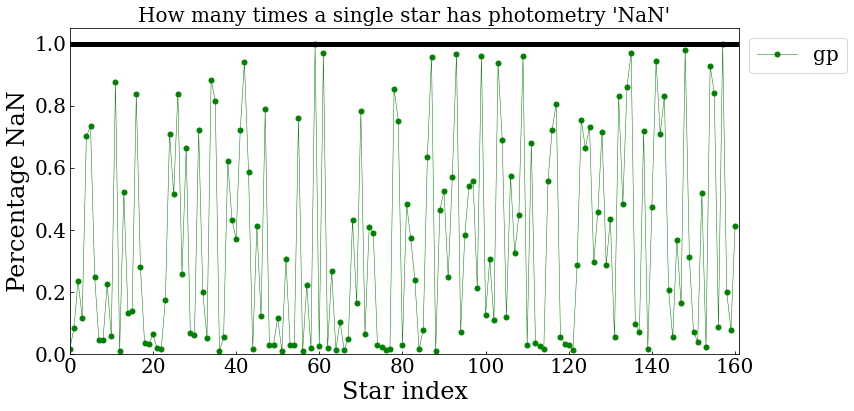

Number of included stars for filter ip = 161/161 (100.0%)


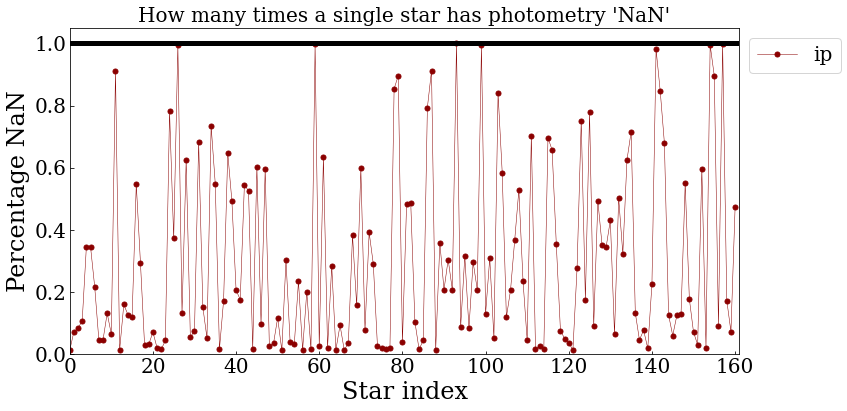

Number of included stars for filter rp = 161/161 (100.0%)


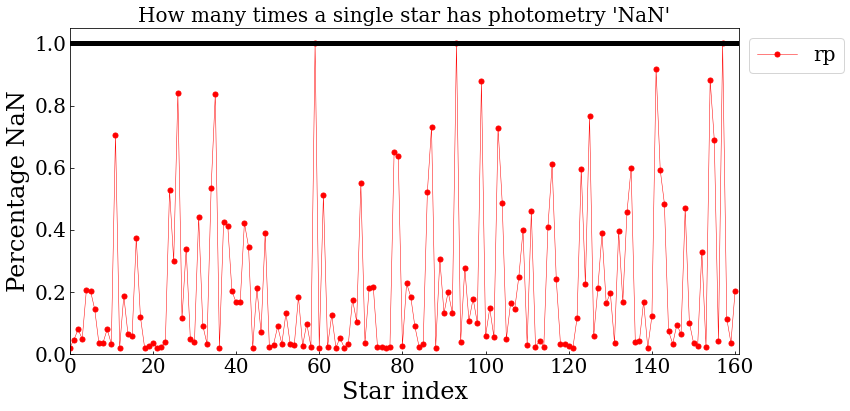

In [96]:
# Make a mask to filter bad stars
maxp_NaN_s = 1 # maximum percentage of NaN's across all filters before it is excluded ##MAKE THIS FILTER SPECIFIC?
star_nan = {} # number of 'NaN' for each star in certain filter
smask = {} # mask of stars included after selection in certain filter
corN_stars = {} # amount of stars included after selection in certain filter
for f in filt:
    star_nan[f] = np.sum(np.isnan(flux[f]),axis=0) 
    smask[f] = (star_nan[f]/NimgINf[f]) <= maxp_NaN_s
    corN_stars[f] = np.sum(smask[f])

# Plotting the amount of NaN per star, if below red line -> star is included
fplotcolor = {'gp':'green','ip':'darkred','rp':'red'} #different colours
for f in filt:
    plt.figure(figsize=(12,6))
    plt.plot(star_nan[f]/NimgINf[f],marker='.',label=f,linewidth=0.5,markersize=10,c=fplotcolor[f])
    print ("Number of included stars for filter {} = {}/{} ({:.1f}%)"\
           .format(f,corN_stars[f],N_stars,100*corN_stars[f]/N_stars))
    plt.plot([0,N_stars],[maxp_NaN_s,maxp_NaN_s],c='black',linewidth=5)
    plt.axis(xmin=-.01,ymin=0,xmax=N_stars+.01)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title("How many times a single star has photometry 'NaN'")
    plt.xlabel("Star index")
    plt.ylabel("Percentage NaN")
    plt.savefig("../Slide_pics/filtered_stars_"+f)
    plt.show()



In [97]:
# Simplifying the masks so combining the filter & photometry mask
flux_excls = {}
fluxerr_excls = {}
for f in filt:
    tmp1 = []
    tmp2 = []
    for i in range(NimgINf[f]):
        tmp1.append(flux[f][i][smask[f]])
        tmp2.append(fluxerr[f][i][smask[f]])
    flux_excls[f] = np.array(tmp1)
    fluxerr_excls[f] = np.array(tmp2)

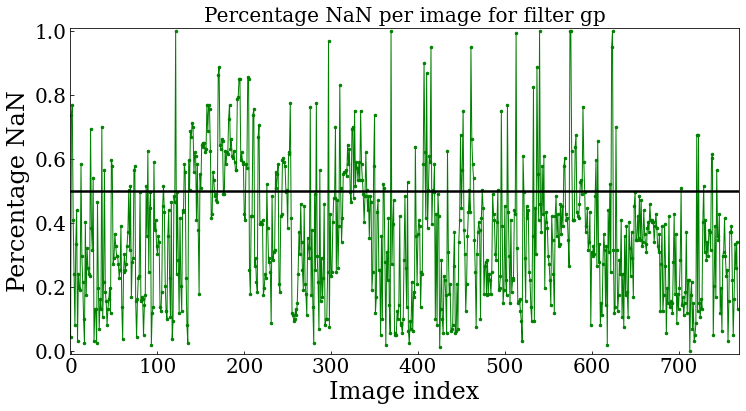

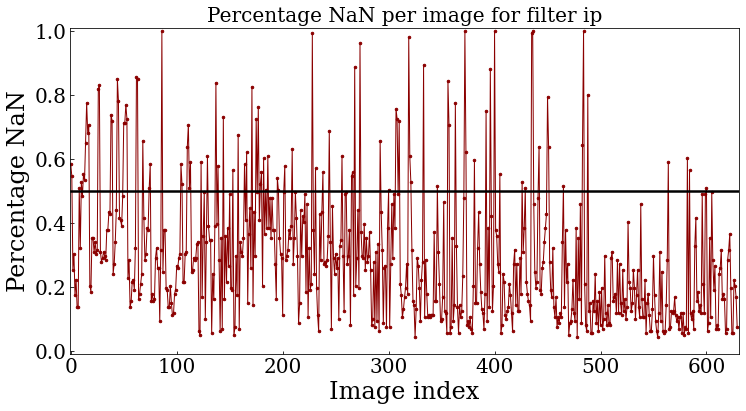

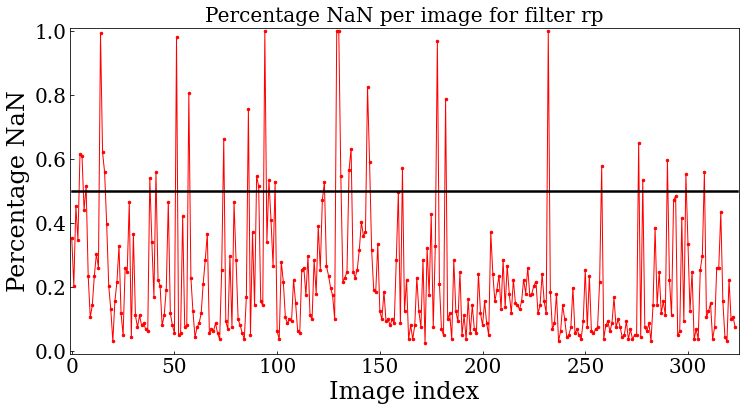

Nr of included images in filter gp = 584/769 (75.9%)
Nr of included images in filter ip = 533/630 (84.6%)
Nr of included images in filter rp = 289/324 (89.2%)


In [98]:
#Make a mask to filter bad photometry
maxp_NaN_e = .5 #maximum percentage of NaN before file is excluded
epoch_NaN = {}
emask = {}
for f in filt:
    tmp = np.sum(np.isnan(flux_excls[f]),axis=1)/corN_stars[f]
    epoch_NaN[f] = tmp
    emask[f] = tmp <= maxp_NaN_e

for f in filt:
    #plt.plot(np.sum(np.isnan(flux[f]),axis=1)/N_stars,c='b',linewidth=1)
    #plt.plot([0,len(epoch_NaN[f])],[maxp_NaN_e,maxp_NaN_e], c='r')
    #plt.title("Percentage NaN per image for filter "+f+" (for all stars)")
    #plt.ylabel("Percentage NaN")
    #plt.xlabel("Image index") 
    #plt.axis(ymin=-.01,ymax=1.01)
    #plt.show()
    plt.figure(figsize=(12,6))
    plt.plot(epoch_NaN[f],marker='.',linewidth=1,markersize=5,c=fplotcolor[f])
    plt.plot([0,len(epoch_NaN[f])],[maxp_NaN_e,maxp_NaN_e], c='black',linewidth=2.5)
    plt.title("Percentage NaN per image for filter "+f)#+" (with only accepted stars)")
    plt.ylabel("Percentage NaN")
    plt.xlabel("Image index") 
    plt.axis(ymin=-.01,ymax=1.01,xmin=-1,xmax=NimgINf[f]+1)
    plt.savefig("../Slide_pics/filtered_images_"+f)
    plt.show()

for f in filt:
    print ("Nr of included images in filter {} = {}/{} ({:.1f}%)"\
           .format(f, np.sum(emask[f]), len(emask[f]), 100*float(np.sum(emask[f]))/float(len(emask[f]))))

In [99]:
# Simplifying the masks so combining the filter & photometry mask
corflux = {}
corfluxerr = {}
corairmass = {}
corfits_name = {}
corfiles = {}
corepoch = {} # make a corrected epoch where the bad photometry is excluded
for f in filt:
    corflux[f] = flux_excls[f][emask[f]]
    corfluxerr[f] = fluxerr_excls[f][emask[f]]
    corairmass[f] = airmass[f][emask[f]]
    corfits_name[f] = fits_name[f][emask[f]]
    corfiles[f] = files[f][emask[f]]
    corepoch[f] = epoch[f][emask[f]]

# Making a mask for the stars without any NaN in their data after exclusion of bad fotometry images
star_withoutnan = {}
print ("Nr of stars without NaN after exclusion bad stars & bad photometry: = {}/{}")
for f in filt:
    star_withoutnan[f] = np.sum(np.isnan(corflux[f]), axis=0) == 0
    print ("Filter {} = {}/{} ({:.1f}%)".format(f,np.sum(star_withoutnan[f]),corN_stars[f],\
                                            100*np.sum(star_withoutnan[f])/corN_stars[f]))

Nr of stars without NaN after exclusion bad stars & bad photometry: = {}/{}
Filter gp = 53/161 (32.9%)
Filter ip = 46/161 (28.6%)
Filter rp = 66/161 (41.0%)


In [100]:
#plotting the flux against epoch for different filters with bad photometry files removed

#for f in filt:
#    plt.figure(figsize=(12,6))
    #for s in range(corN_stars[f]):
#    plt.plot(corepoch[f],corflux[f],marker='.',linestyle='dashed',linewidth=0.5,markersize=2)
#    plt.title("Flux of star plotted against epoch for filter "+f+" (for " + str(corN_stars[f])+' selected stars)')
#    plt.xlabel("Epoch (MJD)")
#    plt.ylabel("Flux (counts)")
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
#    plt.yscale('log')
#    plt.axis(ymin=1e3,ymax=5e6)
#    plt.savefig("../Slide_pics/flux_after_filtering_"+f)
#    plt.show()

In [101]:
# apparently there are some datafiles where the flux & fluxerr is 0.0 ....
for f in filt:
    for e in range(len(corepoch[f])):
        for s in range(corN_stars[f]):
            if corfluxerr[f][e,s] ==0:
                print (corfiles[f][e])
                print (f,e,s,corfluxerr[f][e,s])


# Calculating the meanflux for each star and normalisation factor for each epoch to get double normalised flux

In [102]:
#I want to plot the normalised flux so I first want to devide the flux of all stars by their own mean.
# Decided to do it all with weighted mean

# Calculate the weighted mean flux for each star & the error in this weighted mean
meanflux_star = {}
meanfluxerr_star = {}
for f in filt:
    tmp = []
    tmp2 = []
    for i in range(corN_stars[f]):
        nonNaN = np.isnan(corflux[f][:,i]) == False #exclude non NaN datapoints from calculation
        nonNaN *= np.isnan(corfluxerr[f][:,i]) == False
        if np.sum(nonNaN) != 0:
            weight = (1/corfluxerr[f][:,i][nonNaN])**2
            mfluxstar = np.sum(corflux[f][:,i][nonNaN]*weight)/np.sum(weight)
            tmp.append(mfluxstar)
            tmp2.append(1/np.sum(weight))
        else:
            print ("meanflux_star: Filter {} and star {} has all NaN values".format(f,i))
            tmp.append(np.NaN)
            tmp2.append(np.NaN)
    plt.show()
    meanflux_star[f] = np.array(tmp)
    meanfluxerr_star[f] = np.array(tmp2)
    #print (meanflux_star)

print ("Amount of NaN values in meanflux(err)_star:")
for f in filt:
    print (f,np.sum(np.isnan(meanflux_star[f])))
    print (f,np.sum(np.isnan(meanfluxerr_star[f])))

#Then I want to devide the fluxes of all stars at one epoch by the normalised mean of all stars at that epoch.
# If the stars are all constant, it should result in a straight line.

# Calculate the weighted mean normalised flux for each epoch & the rror in this weighted mean normalised flux
normfac_epoch = {}
normfacerr_epoch = {}
for f in filt:
    tmp = []
    tmp2 = []
    for i in range(len(corepoch[f])):
        #Exclude the NaN's for the mean
        nonNaN = np.isnan(corflux[f][i]) == False
        nonNaN *= np.isnan(meanflux_star[f])== False #sometimes 
        #print (f,np.sum(nonNaN), np.sum(nonNaN==False))
        if np.sum(nonNaN) != 0:
            mfluxep = (corflux[f][i][nonNaN]/meanflux_star[f][nonNaN])
            mfluxerrep = np.sqrt((corfluxerr[f][i]/meanflux_star[f])**2 +\
                                 (corflux[f][i]*meanfluxerr_star[f]/(meanflux_star[f]**2))**2)[nonNaN]
            weight = 1/(mfluxerrep**2)
            tmp.append(np.sum(weight*mfluxep)/np.sum(weight))
            tmp2.append(np.sum(weight))
        else:
            print ("normfac_epoch: Filter {} and epoch {} has all NaN values".format(f,i))
            tmp.append(np.NaN)
            tmp2.append(np.NaN)
    normfac_epoch[f] = np.array(tmp)
    normfacerr_epoch[f] = np.array(tmp2)


print ("Amount of NaN values in normfac(err)_epoch:")
for f in filt:
    print (f,np.sum(np.isnan(normfac_epoch[f])))
    print (f,np.sum(np.isnan(normfacerr_epoch[f])))

# Calculate the flux of each star, corrected by the normalised mean flux at a certain epoch
normflux = {}
normfluxerr = {}
for f in filt:
    tmp = []
    tmp2 = []
    for i in range(corN_stars[f]):
        nflux = corflux[f][:,i]/normfac_epoch[f]
        nfluxerr = np.sqrt((corfluxerr[f][:,i]/normfac_epoch[f])**2 + \
                           (corflux[f][:,i]*normfacerr_epoch[f]/(normfac_epoch[f]**2))**2)
        tmp.append(nflux)
        tmp2.append(nfluxerr)
    normflux[f] = np.array(tmp).transpose()
    normfluxerr[f] = np.array(tmp2).transpose()
    #print (normflux[f])

print ("Amount of NaN values in normflux(err):")
for f in filt:
    print (f,np.sum(np.isnan(normflux[f])), "vs", np.sum(np.isnan(corflux[f])),' before')
    print (f,np.sum(np.isnan(normfluxerr[f])), "vs", np.sum(np.isnan(corfluxerr[f])),' before')


#Calculate the flux of each star, correct by the normalised mean flux at a certain epoch, devided by their own mean
# (so the double normalised flux)



meanflux_star: Filter ip and star 93 has all NaN values
meanflux_star: Filter rp and star 59 has all NaN values
meanflux_star: Filter rp and star 93 has all NaN values
meanflux_star: Filter rp and star 157 has all NaN values
Amount of NaN values in meanflux(err)_star:
gp 0
gp 0
ip 1
ip 1
rp 3
rp 3
Amount of NaN values in normfac(err)_epoch:
gp 0
gp 0
ip 0
ip 0
rp 0
rp 0
Amount of NaN values in normflux(err):
gp 25532 vs 25532  before
gp 25532 vs 25532  before
ip 19327 vs 19327  before
ip 19327 vs 19327  before
rp 7679 vs 7679  before
rp 7679 vs 7679  before


In [103]:
#Plot the flux of all stars normalised with their own flux to check if it worked
#for f in filt:
#    for i in np.arange(corN_stars[f])[star_withoutnan[f]]:
#        plt.errorbar(corepoch[f],corflux[f][:,i]/meanflux_star[f][i],yerr=corfluxerr[f][:,i]/meanflux_star[f][i]\
#                     ,fmt='--.',label=i)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    #plt.yscale('log')
#    plt.title(f+" normalised with flux of self (without NaN stars)")
#    plt.xlabel("Epoch [MJD]")
#    plt.ylabel("Corrected Flux")
#    plt.axis(ymin=0,ymax=2)
#    plt.show()
#    for i in np.arange(corN_stars[f]):#[star_withoutnan[f]]:
#        plt.errorbar(corepoch[f],corflux[f][:,i]/meanflux_star[f][i],yerr=corfluxerr[f][:,i]/meanflux_star[f][i]\
#                     ,fmt='--.',label=i)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    #plt.yscale('log')
#    plt.title(f+" normalised with flux of self (with NaN stars)")
#    plt.xlabel("Epoch [MJD]")
#    plt.ylabel("Corrected Flux")
#    plt.axis(ymin=0,ymax=2)
#    plt.show()

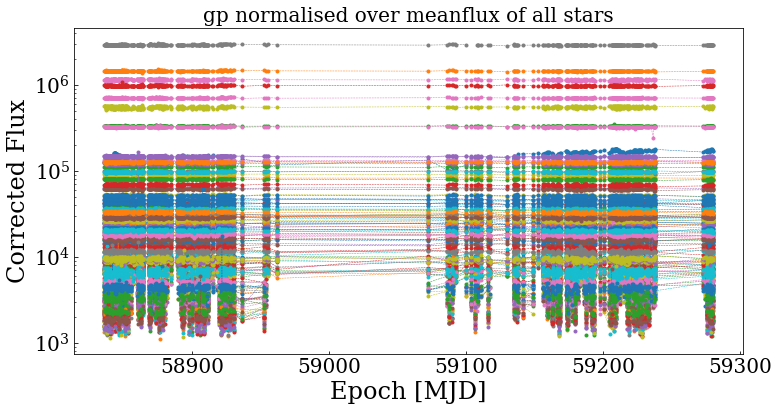

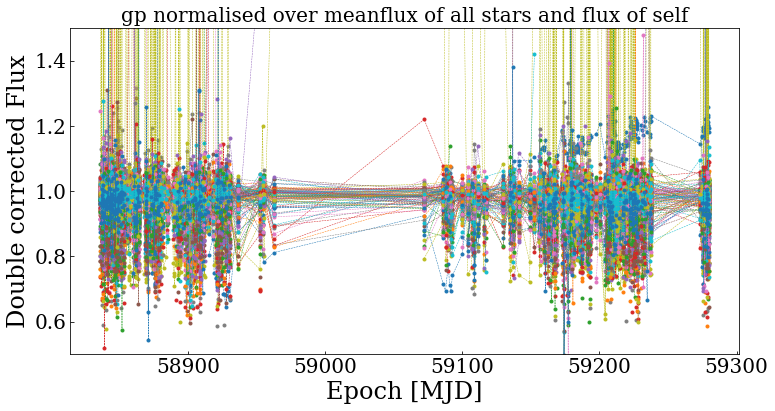

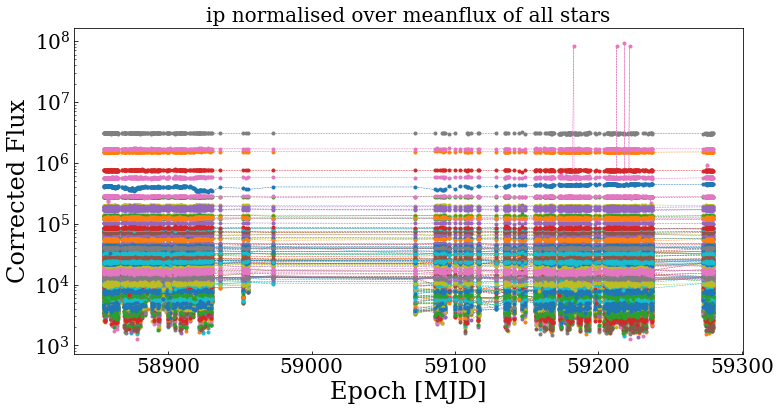

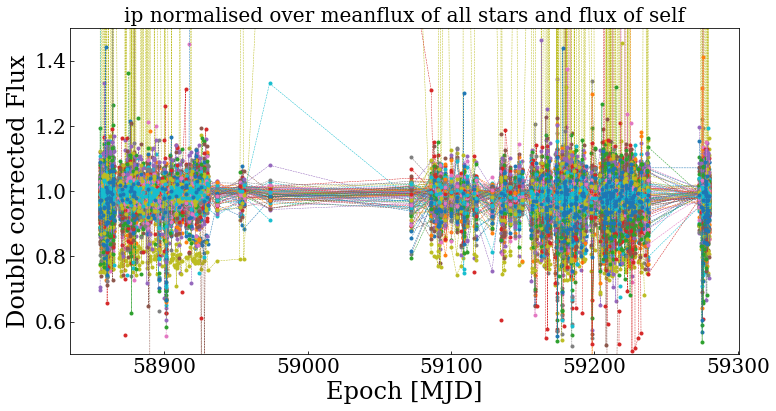

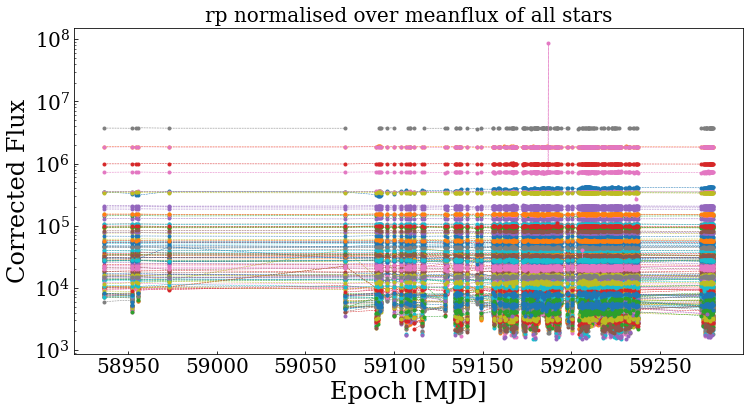

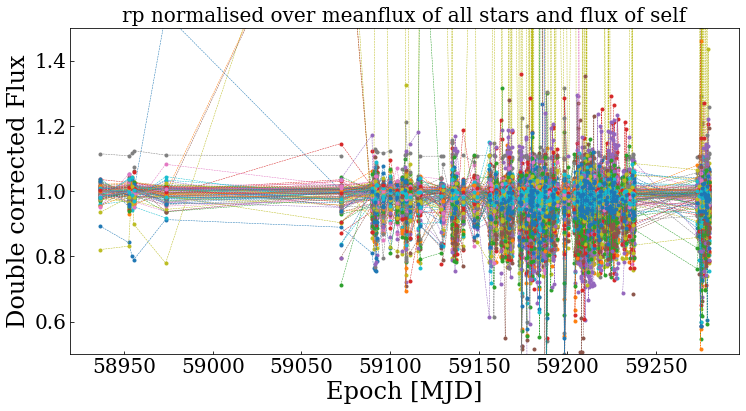

In [104]:
#Plot the epoch-corrected stellar flux.
#Also plot the double corrected plots (which is a straight line for constant stars)
for f in filt:
    plt.figure(figsize=(12,6))
    #for i in np.arange(corN_stars[f])[star_withoutnan[f]]:
    plt.plot(corepoch[f],normflux[f],linestyle='dashed',marker='.', linewidth=0.5)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.title(f+" normalised over meanflux of all stars")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.show()
    plt.figure(figsize=(12,6))
    #for i in np.arange(corN_stars[f])[star_withoutnan[f]]:
    plt.plot(corepoch[f],normflux[f]/meanflux_star[f],linestyle='dashed',marker='.',linewidth=0.5)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f+" normalised over meanflux of all stars and flux of self")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Double corrected Flux")
    #plt.yscale('log')
    plt.axis(ymin=0.5,ymax=1.5)
    plt.savefig('../Slide_pics/Double_normalised_flux_'+f)
    plt.show()

# Retreiving Gaia colours for all the stars to apply filter

In [105]:
# Extract the magnitudes from the stars in 400" radius around J0600
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

# Coords of J0600: 90.00316332976436 -31.007910088843165
coord = SkyCoord(ra=90.003163, dec=-31.007910, unit=(u.degree, u.degree), frame='icrs')
radius = u.Quantity(400, u.arcsec)
Gaia.ROW_LIMIT = -1
j = Gaia.cone_search_async(coord, radius)
r = j.get_results()
r.pprint()

INFO: Query finished. [astroquery.utils.tap.core]
    solution_id             designation          ...          dist         
                                                 ...                       
------------------- ---------------------------- ... ----------------------
1635721458409799680 Gaia DR2 2891196718939580672 ... 0.00013201426578689563
1635721458409799680 Gaia DR2 2891196684579844864 ...   0.009094052279059428
1635721458409799680 Gaia DR2 2891196753298345472 ...   0.010658205399898254
1635721458409799680 Gaia DR2 2891196684579845376 ...   0.011317279008876314
1635721458409799680 Gaia DR2 2891196753297490304 ...   0.012358430209092582
1635721458409799680 Gaia DR2 2891196920800325760 ...   0.013193050363307734
1635721458409799680 Gaia DR2 2891196753299317632 ...   0.013872023467184842
1635721458409799680 Gaia DR2 2891196680282145152 ...    0.01664899863064252
1635721458409799680 Gaia DR2 2891196684578034688 ...   0.016696369787614993
1635721458409799680 Gaia DR2 289119692

In [106]:
# Get the star number and coordinates for the selected stars
corstars = {}
corstar_coords = {}
standards = ascii.read('standards.txt')
#print (standards)
for f in filt:
    corstars[f] = np.arange(N_stars)[smask[f]] # Starnr is counting from 1 to 161
    tmp1 = np.array(standards[smask[f]]['RA'])
    tmp2 = np.array(standards[smask[f]]['Dec'])
    corstar_coords[f] = np.array([tmp1,tmp2]).transpose()

In [107]:
# To link the correct Gaia entries to our stars, select star with nearest coordinates
def find_stars(xobj_list, yobj_list, xlist, ylist, f):
    # Make a matrix with each column the same xlist or ylist.
    # The number of columns is the number of objects in standards.txt
    xmatrix = np.array(list(xlist)*len(xobj_list)).reshape([len(xobj_list),len(xlist)]).transpose()
    ymatrix = np.array(list(ylist)*len(yobj_list)).reshape([len(yobj_list),len(ylist)]).transpose()
    
    distance_matrix = np.sqrt((xmatrix-xobj_list)**2 + (ymatrix-yobj_list)**2)
    
    indices = np.argmin(distance_matrix, axis=0)
    """
    # Make plot to check data
    plt.figure(figsize=(16,16))
    plt.scatter(xlist,ylist,c='b',s=4)
    plt.scatter(xobj_list, yobj_list, c='red', s=2)
    plt.plot([2000,2025],[0,0],c='r')
    for i in range(nr_stars):
    	plt.plot([xobj_list[i],xlist[indices[i]]],[yobj_list[i],ylist[indices[i]]], linestyle='dashed',c='r',linewidth=1)
    plt.title(f)
    plt.show()
    """
    return indices, np.diag(distance_matrix[indices])
    #the diagonal gives the distance from each selected object to the closest object

def distance(xobj,yobj, xlist,ylist):
    'find the distance between target & objects round it, returns list with distances in pixels'
    d = (xobj-xlist)**2 + (yobj-ylist)**2
    return np.sqrt(d)

In [108]:
# Making a mask for the gaia data to extract the data from the relevant stars
gaiamask = {}
for f in filt:
    stars_arg, d = find_stars(corstar_coords[f][:,0],corstar_coords[f][:,1],np.array(r['ra']),np.array(r['dec']),f)
    gaiamask[f] = stars_arg
    max_d = 1 #if distance is bigger than 1", it is to much
    if np.sum(d >= max_d) != 0:
        print ("Stars that are too distant")
        print (f, np.arange(N_stars)[d >= max_d])
    plt.show()

# Making a dictionary for the gaia magnitude of the selected stars
gaia_mag = {}
gaia_mag[filt[0]] = np.array(r['phot_g_mean_mag'][gaiamask[filt[0]]]) #gaia filter g, not gp
gaia_mag[filt[2]] = np.array(r['phot_rp_mean_mag'][gaiamask[filt[2]]])


# Making a dictionary for the gaia colours for the selected stars in each filter (c=rp-g in this case)
gaia_c = {}
for f in filt:
    c = np.array(r['phot_rp_mean_mag'][gaiamask[f]]) - np.array(r['phot_g_mean_mag'][gaiamask[f]])
    gaia_c[f] = c

# Extract the Gaia J0600 data
# Coords of J0600: 90.00316332976436 -31.007910088843165
d = distance(90.00316332976436, -31.007910088843165, r['ra'],r['dec'])

J0600_gaia = r[np.argmin(d)]


# Extract gaia magnitudes & colour for J0600
J0600_gaiamag = {}
J0600_gaiamag[filt[0]] = J0600_gaia['phot_g_mean_mag'] #gaia filter g, not gp
J0600_gaiamag[filt[2]] = J0600_gaia['phot_rp_mean_mag']
print (J0600_gaiamag)

J0600_c = J0600_gaia['phot_rp_mean_mag']-J0600_gaia['phot_g_mean_mag']

{'gp': 13.146582, 'rp': 12.333511}


In [109]:
# Make a plot to check if the right stars are selected
#or f in filt:
#    plt.figure(figsize=(12,12))
    #plt.scatter(standards['RA'][0],standards['Dec'][0], c='r',s=15)
#    plt.scatter(corstar_coords[f][:,0],corstar_coords[f][:,1], c='r',s=50)
#    plt.scatter(r['ra'],r['dec'],c='b',s=25)
#    plt.scatter(r['ra'][gaiamask[f]],r['dec'][gaiamask[f]],c='grey',s=10)
#    plt.xlabel("Right Ascension")
#    plt.ylabel("Declination")
    #plt.axis(xmin=89.90,xmax=89.94,ymin=-30.96,ymax=-30.92)
    #plt.axis(xmin=89.86,xmax=90.01,ymin=-31.02,ymax=-30.88)
#    plt.title(f)
#    plt.show()

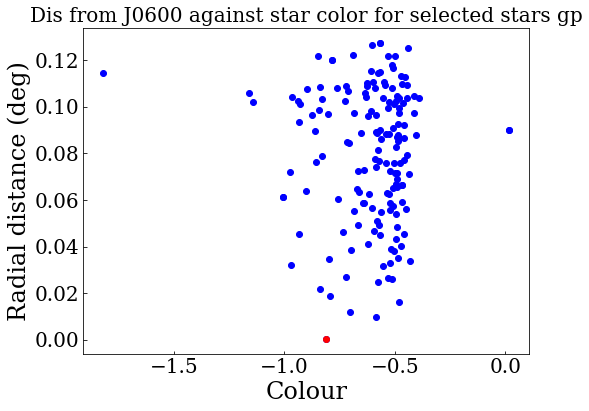

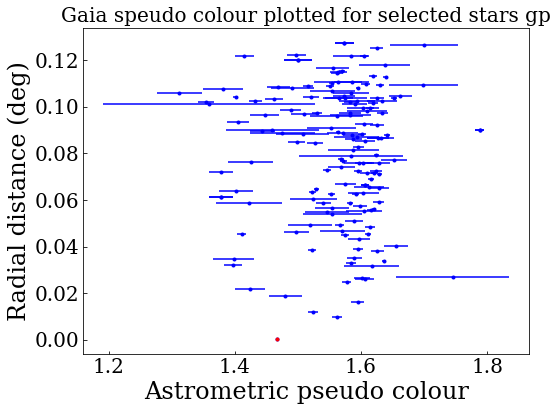

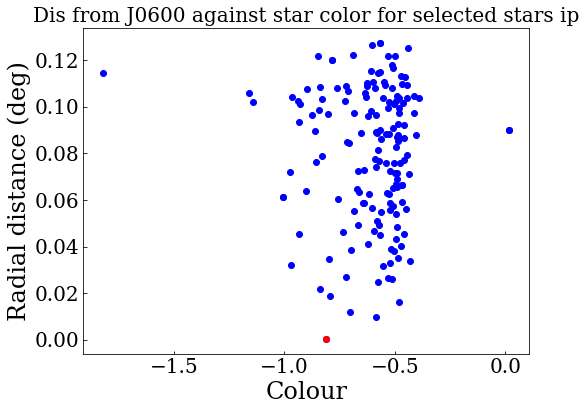

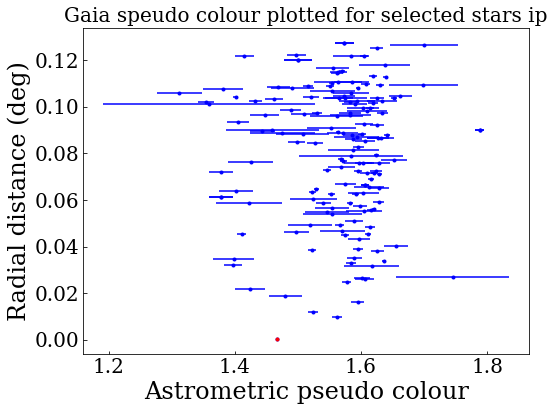

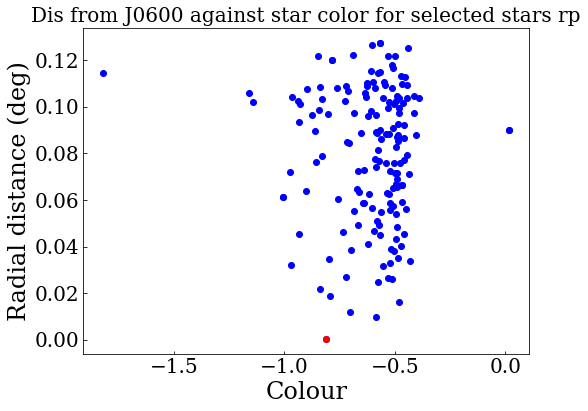

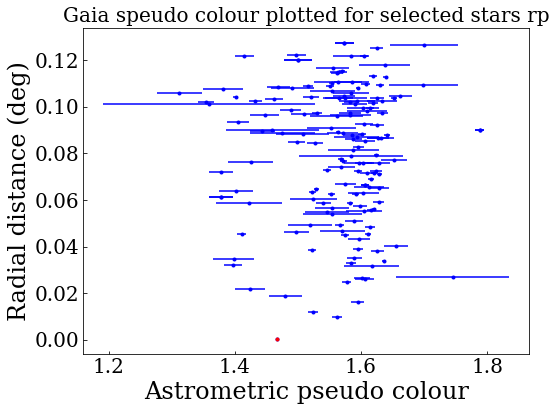

In [111]:
# Radial distance to J0600 plotted as function of colour

for f in filt:
    d_to_J0600 = distance(90.00316332976436, -31.007910088843165,r['ra'][gaiamask[f]],r['dec'][gaiamask[f]])
    
    plt.scatter(gaia_c[f], d_to_J0600,c='b')
    plt.scatter((J0600_gaia['phot_rp_mean_mag']-J0600_gaia['phot_g_mean_mag']),np.min(d_to_J0600),c='r')
    plt.xlabel('Colour')
    plt.ylabel('Radial distance (deg)')
    plt.title('Dis from J0600 against star color for selected stars '+f)
    plt.show()

    plt.errorbar(r['astrometric_pseudo_colour'][gaiamask[f]], d_to_J0600,\
                 xerr = r['astrometric_pseudo_colour_error'][gaiamask[f]],fmt='.', c='b')
    plt.errorbar(J0600_gaia['astrometric_pseudo_colour'],np.min(d_to_J0600),\
                 xerr=J0600_gaia['astrometric_pseudo_colour_error'],fmt='.',c='r')
    plt.xlabel('Astrometric pseudo colour')
    plt.ylabel('Radial distance (deg)')
    plt.title('Gaia speudo colour plotted for selected stars '+f)
    plt.show()

# Selecting stars to do atmospheric extinction with

In [112]:
# Number of selected stars
nr_selected_stars = 30



In [113]:
# first selecting all stars that have a 'lower colour' than J0600
c_mask = {}
for f in filt:
    c_mask[f] = gaia_c[f] < J0600_c
    
    print ("Pre selected stars in filter {} = {}/{}".format(f, np.sum(c_mask[f]),nr_selected_stars))
    print ("Star numbers for selected stars:",corstars[f][c_mask[f]])

Pre selected stars in filter gp = 23/30
Star numbers for selected stars: [  5  13  23  35  41  47  55  59  61  90  92  96 106 109 112 117 126 128
 132 135 138 146 148]
Pre selected stars in filter ip = 23/30
Star numbers for selected stars: [  5  13  23  35  41  47  55  59  61  90  92  96 106 109 112 117 126 128
 132 135 138 146 148]
Pre selected stars in filter rp = 23/30
Star numbers for selected stars: [  5  13  23  35  41  47  55  59  61  90  92  96 106 109 112 117 126 128
 132 135 138 146 148]


In [114]:
# Then calculating the variance and RMS for each star in the double normalised flux

# Variance
varflux_star = {}
for f in filt:
    tmp = []
    mfsNaN = np.isnan(meanflux_star[f])
    for s in range(corN_stars[f]):
        if mfsNaN[s] == False:
            nonNaN = np.isnan(normflux[f][:,s]) == False
            var = np.var(normflux[f][:,s][nonNaN]/meanflux_star[f][s])
            tmp.append(var)
        else:
            print (f,s, "Will have NaN value in varflux_star")
            tmp.append(np.NaN)
    varflux_star[f] = np.array(tmp)

# RMS
RMSflux_star = {}
for f in filt:
    tmp = []
    mfsNaN = np.isnan(meanflux_star[f])
    for s in range(corN_stars[f]):
        if mfsNaN[s] == False:
            nonNaN = np.isnan(normflux[f][:,s]) == False
            RMS = np.sqrt(np.sum((normflux[f][:,s][nonNaN]/meanflux_star[f][s])**2)/len(normflux[f][:,s][nonNaN]))
            tmp.append(RMS)
        else:
            print (f,s, "Will have NaN value in RMS_star")
            tmp.append(np.NaN)
    RMSflux_star[f] = np.array(tmp)

ip 93 Will have NaN value in varflux_star
rp 59 Will have NaN value in varflux_star
rp 93 Will have NaN value in varflux_star
rp 157 Will have NaN value in varflux_star
ip 93 Will have NaN value in RMS_star
rp 59 Will have NaN value in RMS_star
rp 93 Will have NaN value in RMS_star
rp 157 Will have NaN value in RMS_star


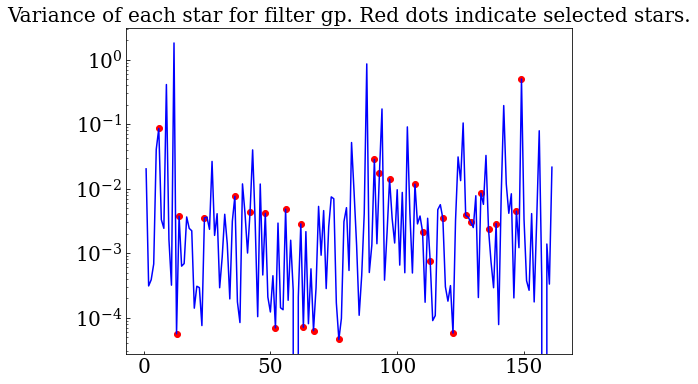

Var stars: [ 12  51  59  62  66  76 121 157]
Colour stars: [  5  13  23  35  41  47  55  59  61  90  92  96 106 109 112 117 126 128
 132 135 138 146 148]


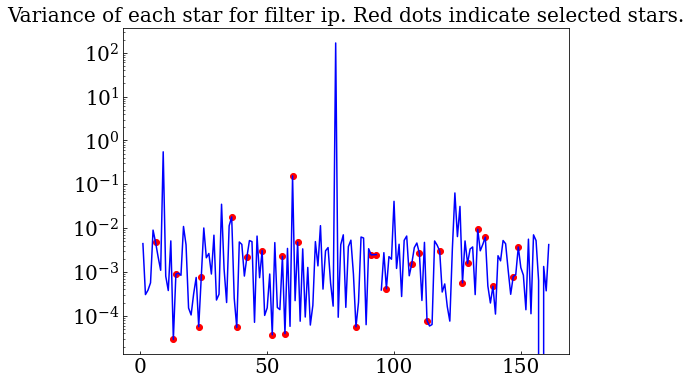

Var stars: [ 12  22  37  51  56  84 157]
Colour stars: [  5  13  23  35  41  47  55  59  61  90  92  96 106 109 112 117 126 128
 132 135 138 146 148]


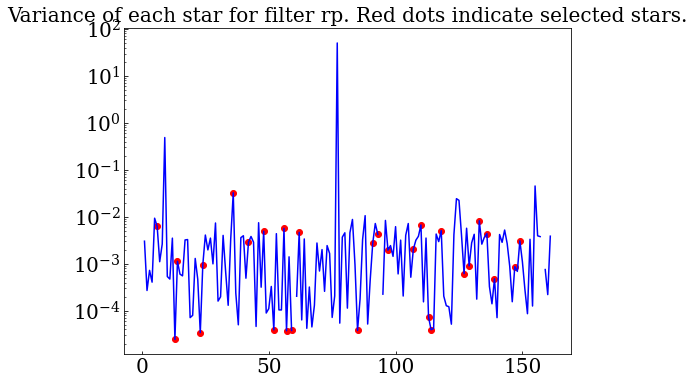

Var stars: [ 12  22  51  56  58  84 113]
Colour stars: [  5  13  23  35  41  47  55  59  61  90  92  96 106 109 112 117 126 128
 132 135 138 146 148]
30
30
30


In [115]:
# Selecting the N stars with least variance
var_mask = {}
RMS_mask = {}

nr_starsleft = {}
for f in filt:
    nr_starsleft[f] = nr_selected_stars - np.sum(c_mask[f])

#select only stars that have not yet been selected by the c_mask
for f in filt:
    sortindex1 = np.argsort(varflux_star[f][c_mask[f]==False])
    sortindex2 = np.argsort(RMSflux_star[f][c_mask[f]==False])
    tmp1 = []
    tmp2 = []
    for s in range(corN_stars[f]):
        tmp1.append(varflux_star[f][s] in (varflux_star[f][c_mask[f]==False])[sortindex1][:nr_starsleft[f]])
        tmp2.append(RMSflux_star[f][s] in (RMSflux_star[f][c_mask[f]==False])[sortindex2][:nr_starsleft[f]])
    var_mask[f] = np.array(tmp1)
    RMS_mask[f] = np.array(tmp2)
    
for f in filt:
    plt.plot(np.arange(corN_stars[f])+1, varflux_star[f],c='b')
    plt.scatter((np.arange(corN_stars[f])+1)[var_mask[f]+c_mask[f]], varflux_star[f][var_mask[f]+c_mask[f]], marker='o',c='r')
    plt.yscale('log')
    plt.title("Variance of each star for filter {}. Red dots indicate selected stars.".format(f))
    plt.show()
    print ("Var stars:", corstars[f][var_mask[f]])
    print ("Colour stars:", corstars[f][c_mask[f]])

# Make a mask for the final selection
finalselec_mask = {}
for f in filt:
    finalselec_mask[f] = var_mask[f] + c_mask[f]
    print (np.sum(finalselec_mask[f]))

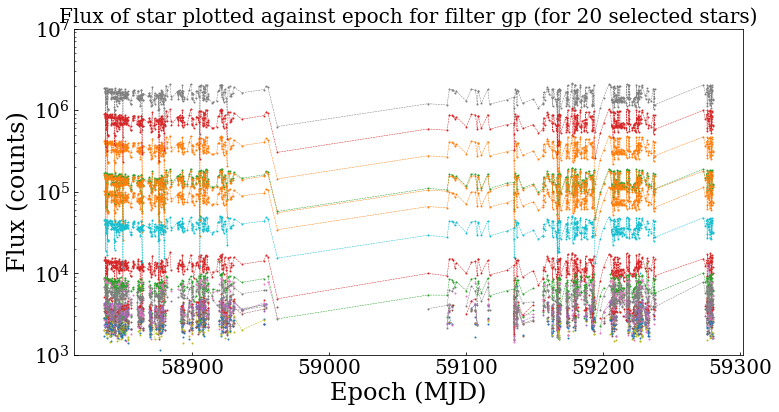

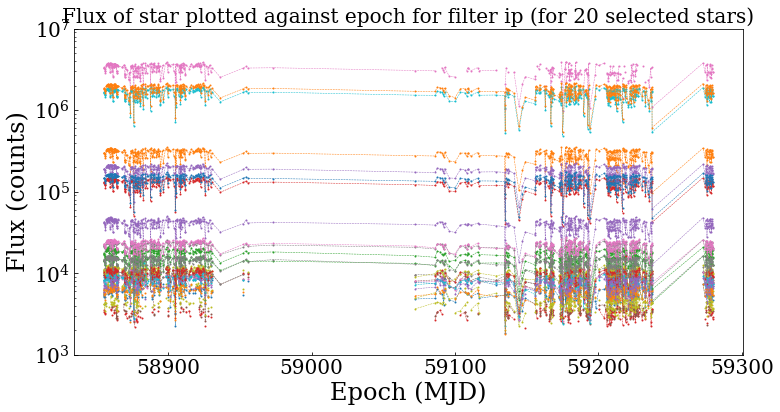

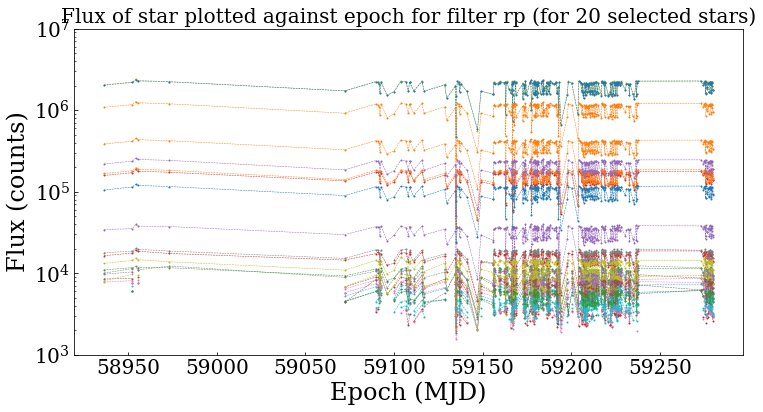

In [117]:
# plot the flux of stable stars

for f in filt:
    plt.figure(figsize=(12,6))
    for s in np.arange(corN_stars[f])[finalselec_mask[f]]:
        plt.plot(corepoch[f],corflux[f][:,s],marker='.',linestyle='dashed',linewidth=0.5,markersize=2)
    plt.title("Flux of star plotted against epoch for filter "+f+" (for 20 selected stars)")
    plt.xlabel("Epoch (MJD)")
    plt.ylabel("Flux (counts)")
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.axis(ymin=1e3,ymax=1e7)
    plt.savefig("../Slide_pics/flux_after_filtering_"+f)
    plt.show()

# Calculate the new normalisation factor with only using the stable stars

In [118]:
# Again create the double normalisation, but now only using the best of the best stars

# Meanflux star stays the same

# Calculate the weighted mean normalised flux for each epoch & the rror in this weighted mean normalised flux
newnormfac_epoch = {}
newnormfacerr_epoch = {}
for f in filt:
    tmp = []
    tmp2 = []
    for i in range(len(corepoch[f])):
        #Exclude the NaN's for the mean
        nonNaN = np.isnan(corflux[f][i]) == False
        nonNaN *= np.isnan(meanflux_star[f])== False #sometimes 
        mask = nonNaN*finalselec_mask[f]
        #print (f,np.sum(nonNaN), np.sum(nonNaN==False))
        if np.sum(nonNaN) != 0:
            mfluxep = (corflux[f][i][mask]/meanflux_star[f][mask])
            mfluxerrep = np.sqrt((corfluxerr[f][i]/meanflux_star[f])**2 +\
                                 (corflux[f][i]*meanfluxerr_star[f]/(meanflux_star[f]**2))**2)[mask]
            weight = 1/(mfluxerrep**2)
            tmp.append(np.sum(weight*mfluxep)/np.sum(weight))
            tmp2.append(np.sum(weight))
        else:
            print ("normfac_epoch: Filter {} and epoch {} has all NaN values".format(f,i))
            tmp.append(np.NaN)
            tmp2.append(np.NaN)
    newnormfac_epoch[f] = np.array(tmp)
    newnormfacerr_epoch[f] = np.array(tmp2)

print ("Amount of NaN values in normfac(err)_epoch:")
for f in filt:
    print (f,np.sum(np.isnan(normfac_epoch[f])))
    print (f,np.sum(np.isnan(normfacerr_epoch[f])))

# Calculate the flux of each star, corrected by the normalised mean flux at a certain epoch
newnormflux = {}
#newnormfluxerr = {}
for f in filt:
    tmp = []
    #tmp2 = []
    for i in np.arange(corN_stars[f])[finalselec_mask[f]]:
        nflux = corflux[f][:,i]/newnormfac_epoch[f]
        #nfluxerr = np.sqrt((corfluxerr[f][:,i]/newnormfac_epoch[f])**2 + \
        #                   (corflux[f][:,i]*newnormfacerr_epoch[f]/(normfac_epoch[f]**2))**2)
        tmp.append(nflux)
        #tmp2.append(nfluxerr)
    newnormflux[f] = np.array(tmp).transpose()
    #normfluxerr[f] = np.array(tmp2).transpose()
    #print (normflux[f])

#print ("Amount of NaN values in normflux(err):")
#for f in filt:
#    print (f,np.sum(np.isnan(normflux[f])), "vs", np.sum(np.isnan(corflux[f])))
#    print (f,np.sum(np.isnan(normfluxerr[f])), "vs", np.sum(np.isnan(corfluxerr[f])))


#Calculate the flux of each star, correct by the normalised mean flux at a certain epoch, devided by their own mean
# (so the double normalised flux)


Amount of NaN values in normfac(err)_epoch:
gp 0
gp 0
ip 0
ip 0
rp 0
rp 0


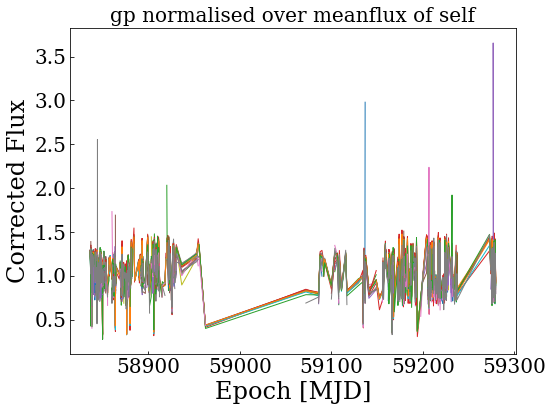

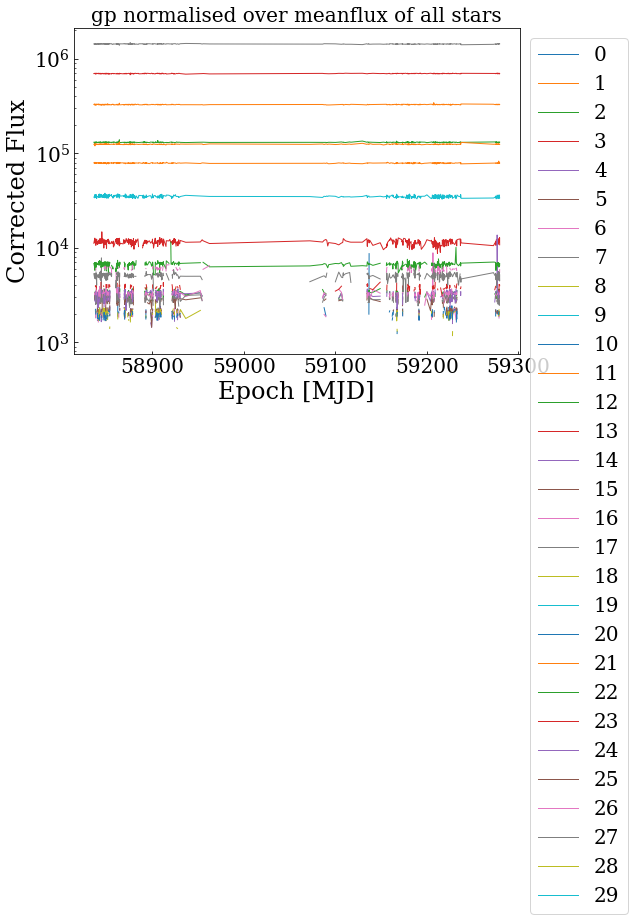

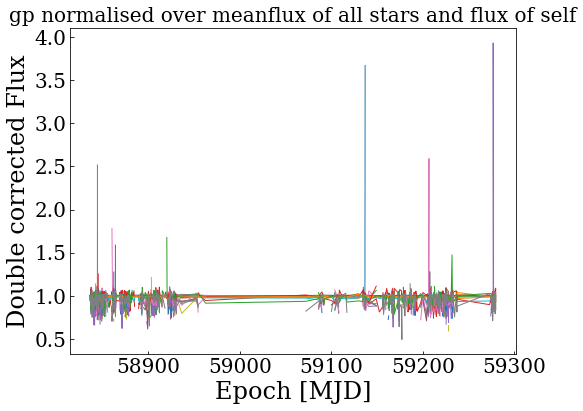

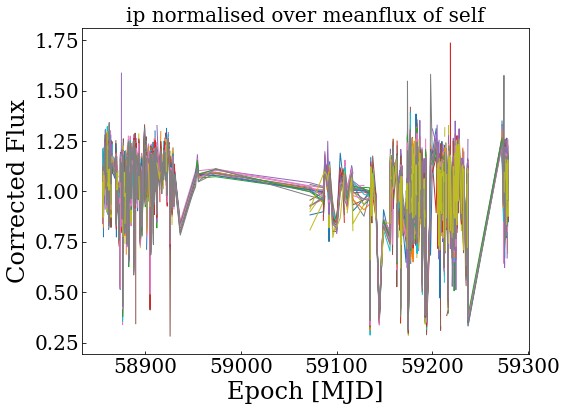

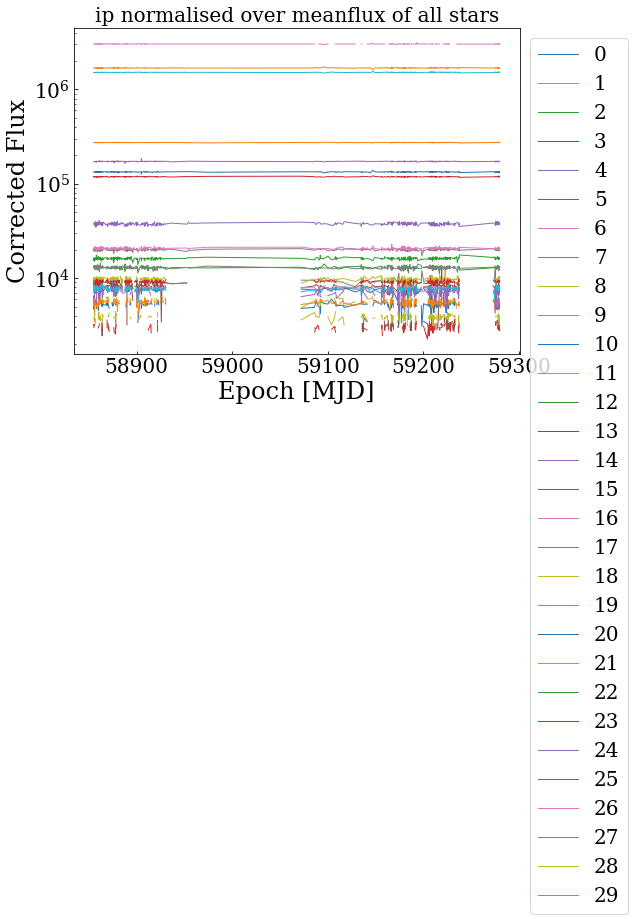

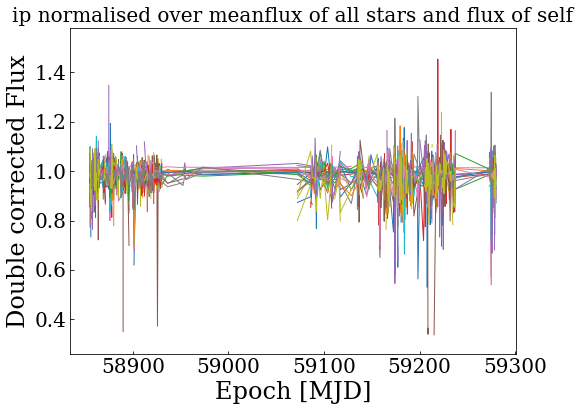

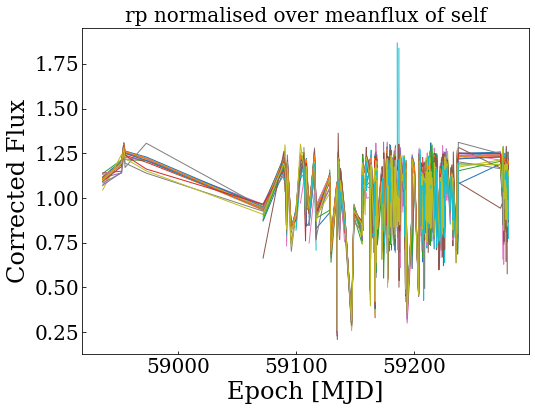

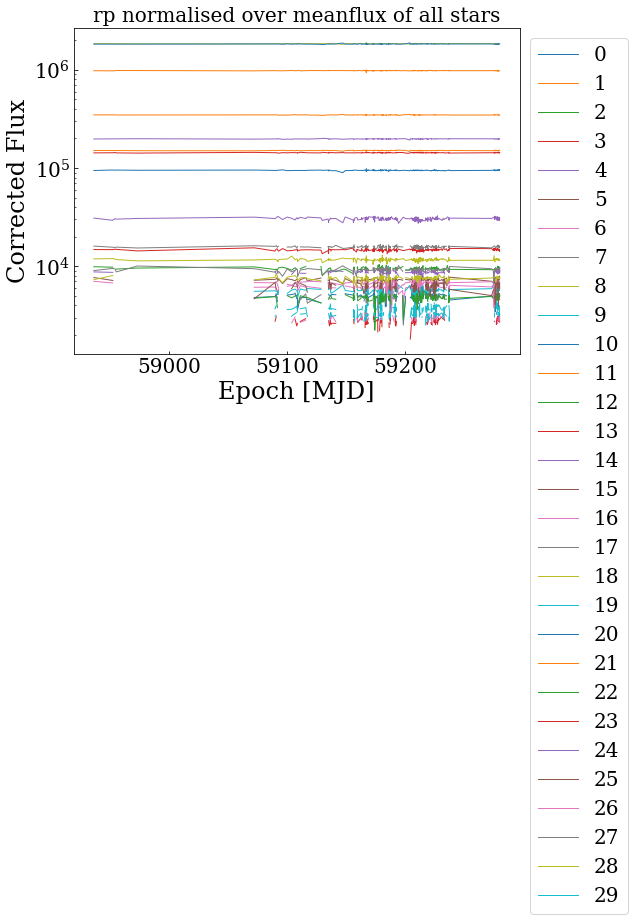

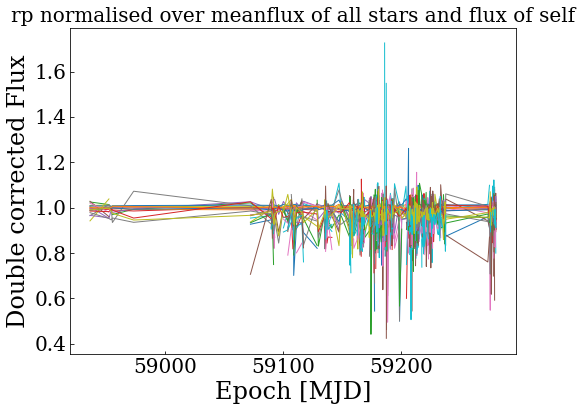

In [120]:
for f in filt:
    #plt.figure(figsize=(8,6))
    for i in np.arange(corN_stars[f])[finalselec_mask[f]]:
        plt.plot(corepoch[f],corflux[f][:,i]/meanflux_star[f][i],linewidth=1, label=i)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    #plt.yscale('log')
    plt.title(f+" normalised over meanflux of self")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.show()
    #plt.figure(figsize=(8,6))
    for i in range(nr_selected_stars):
        plt.plot(corepoch[f],newnormflux[f][:,i],linewidth=1, label=i)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.title(f+" normalised over meanflux of all stars")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.show()
    #plt.figure(figsize=(8,6))
    for i in range(nr_selected_stars):
        plt.plot(corepoch[f],newnormflux[f][:,i]/meanflux_star[f][finalselec_mask[f]][i],linewidth=1, label=str(i))
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f+" normalised over meanflux of all stars and flux of self")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Double corrected Flux")
    #plt.yscale('log')
    #plt.axis(ymin=0.8,ymax=1.1)
    plt.show()

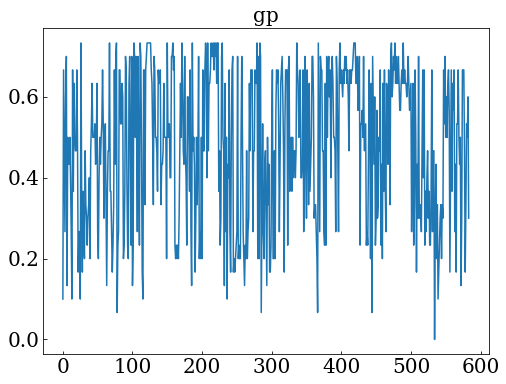

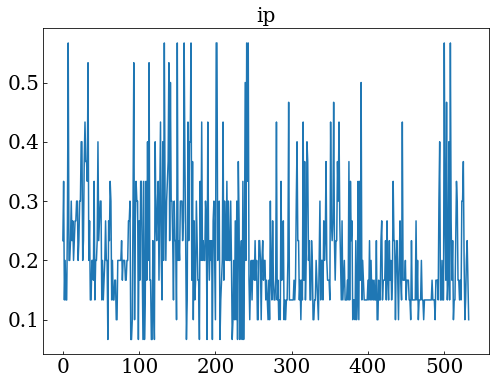

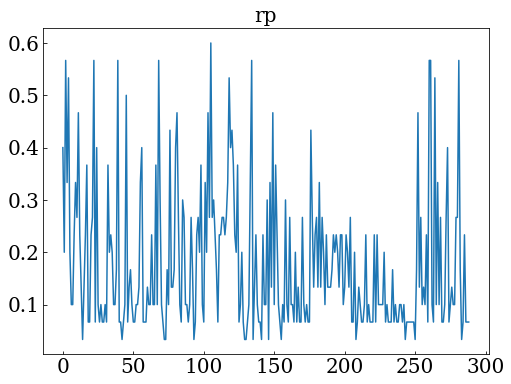

Index with more than 30.0% NaN values in image: (array([  1,   2,   4,   5,   7,   8,   9,  10,  11,  14,  15,  16,  17,
        18,  19,  20,  21,  26,  27,  29,  32,  33,  34,  36,  37,  38,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  64,  65,  66,  67,  68,
        69,  73,  74,  75,  76,  77,  81,  82,  83,  84,  85,  86,  89,
        90,  91,  92,  95,  96,  97,  99, 102, 103, 104, 105, 106, 108,
       109, 111, 112, 113, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 179, 180, 181, 182, 183, 186,
       187, 188, 189, 191, 192, 193, 194, 195, 199, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219

In [122]:
#make another hand picked selection of bad epochs for certain filters:
per_nan = .3


#plot the stars that have the bad photometry easely visible:
noNaN = {}
for f in []: # put in the filter you want
    for s in []: # put in the star
        plt.plot(corepoch[f],newnormflux[f][:,s])
        plt.show()
        noNaN[f] = np.isnan(newnormflux[f][:,s]) == False

        min_noNaNindex = np.argmin(newnormflux[f][:,s][noNaN[f]])
        max_noNaNindex = np.argmax(newnormflux[f][:,s][noNaN[f]])
        print ('Min value:',newnormflux[f][:,s][noNaN[f]][min_noNaNindex])
        print ('Max value:',newnormflux[f][:,s][noNaN[f]][max_noNaNindex])

        print ('Min value index:',np.where(newnormflux[f][:,s] == newnormflux[f][:,s][noNaN[f]][min_noNaNindex]))
        print ('Max value index:',np.where(newnormflux[f][:,s] == newnormflux[f][:,s][noNaN[f]][max_noNaNindex]))

# Also filter for nan values
for f in filt:
    plt.plot(np.sum(np.isnan(newnormflux[f]),axis=1)/len(newnormflux[f][0]))
    plt.title(f)
    plt.show()
for f in filt:
    print ("Index with more than {}% NaN values in image: {}".format(per_nan*100,\
           np.where(np.sum(np.isnan(newnormflux[f]),axis=1)>=per_nan*nr_selected_stars)))
for f in filt:
    print ("{} of {} ({:.5f}%)".format(np.sum(np.sum(np.isnan(newnormflux[f]),axis=1)>=per_nan*nr_selected_stars),\
            len(newnormflux[f]),100*np.sum(np.sum(np.isnan(newnormflux[f]),axis=1)>=per_nan*nr_selected_stars)/len(newnormflux[f])))

In [123]:
# Put the index for the bad images inside this dictionary
bad_img = {}
for f in filt:
    bad_img[f] = np.where(np.sum(np.isnan(newnormflux[f]),axis=1)>=per_nan*nr_selected_stars)[0]

# Now you can mask the epoch & flux values with new_e to filter the bad photometry
new_e = {}
for f in filt:
    msk = []
    for e in np.arange(len(corepoch[f])):
        msk.append(e not in bad_img[f])
    new_e[f] = np.array(msk)

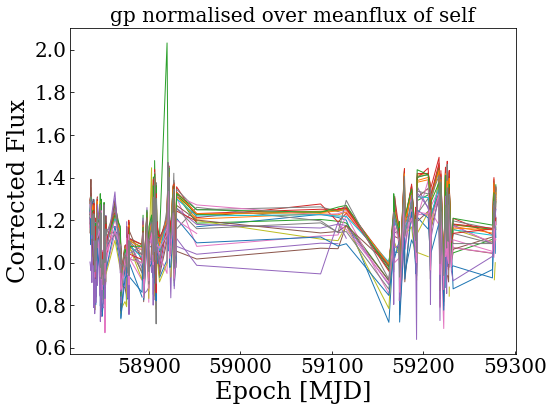

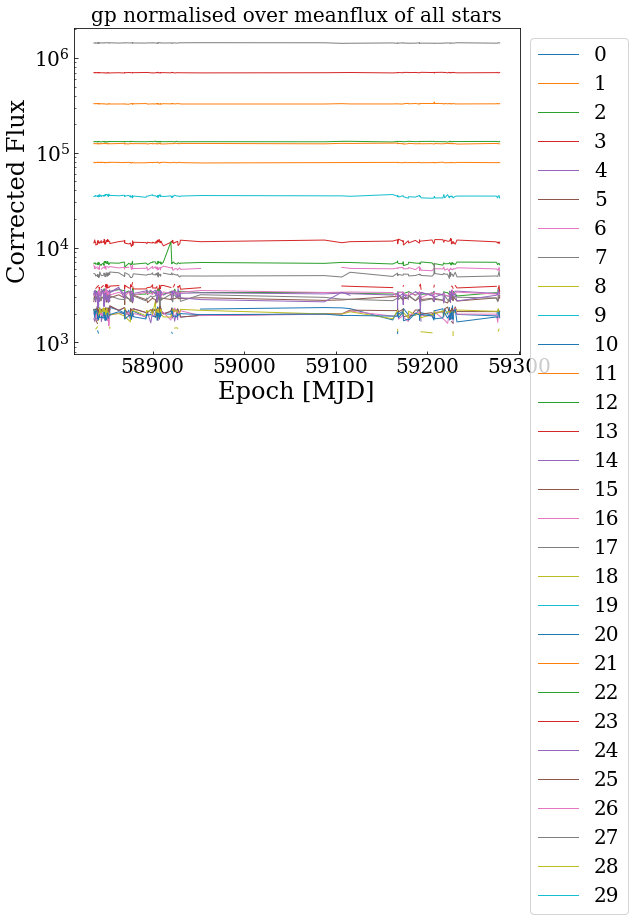

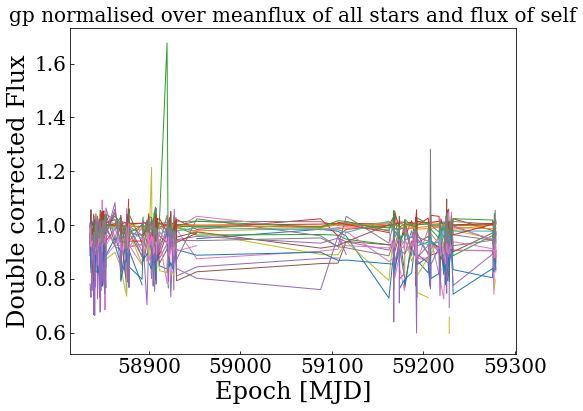

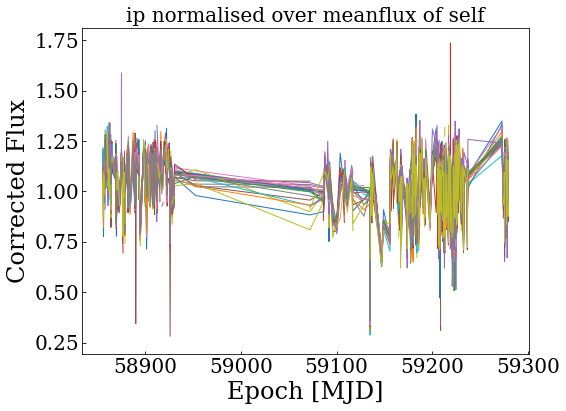

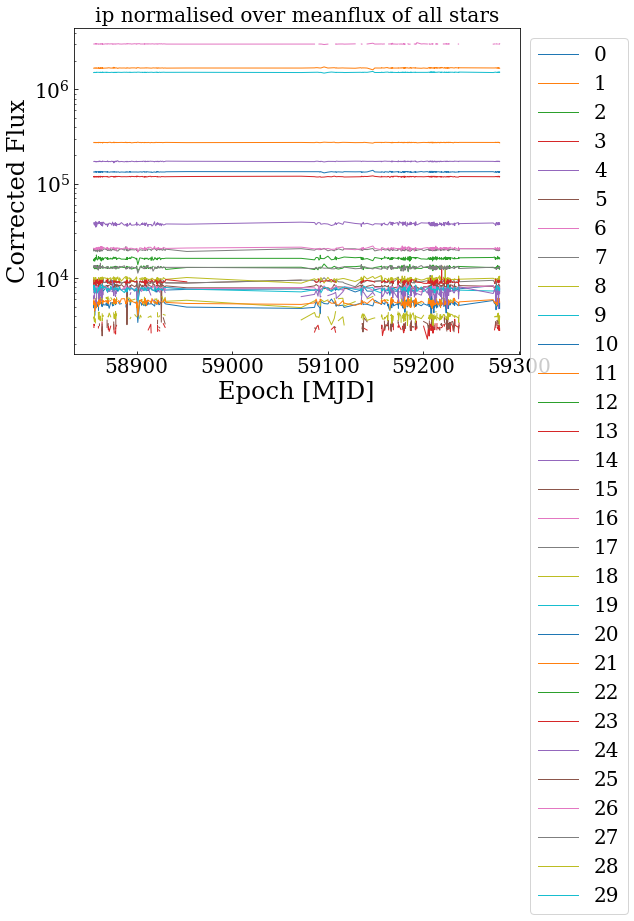

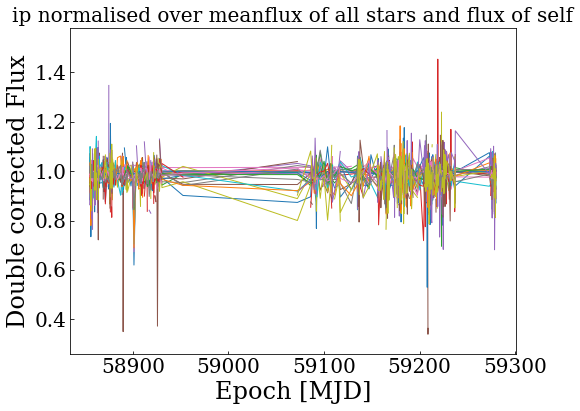

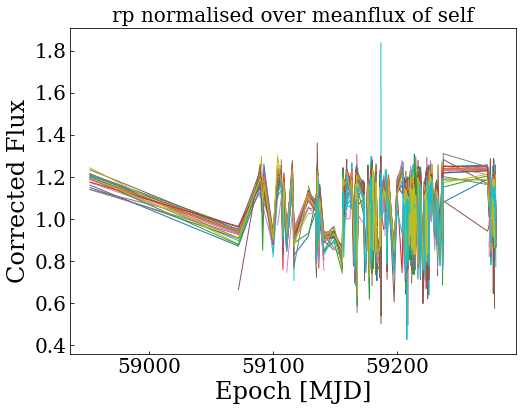

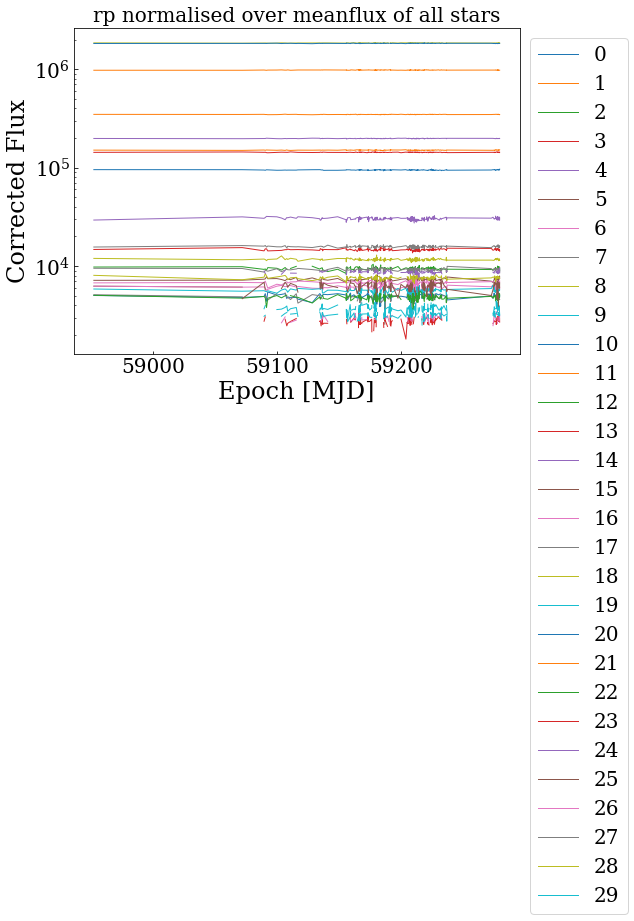

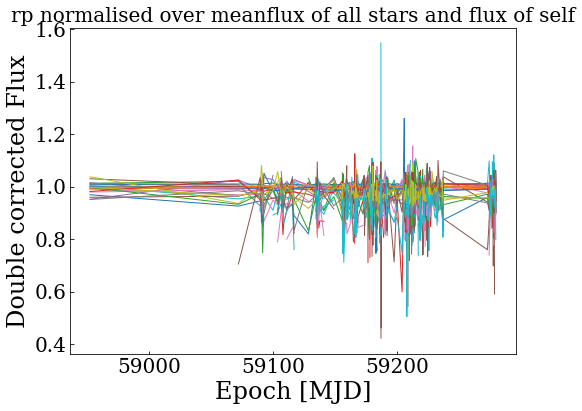

In [124]:
# check if all is well now:
for f in filt:
    #plt.figure(figsize=(8,6))
    for i in np.arange(corN_stars[f])[finalselec_mask[f]]:
        plt.plot(corepoch[f][new_e[f]],(corflux[f][:,i]/meanflux_star[f][i])[new_e[f]],linewidth=1, label=i)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    #plt.yscale('log')
    plt.title(f+" normalised over meanflux of self")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.show()
    #plt.figure(figsize=(8,6))
    for i in range(nr_selected_stars):
        plt.plot(corepoch[f][new_e[f]],newnormflux[f][:,i][new_e[f]],linewidth=1, label=i)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.title(f+" normalised over meanflux of all stars")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.show()
    #plt.figure(figsize=(8,6))
    for i in range(nr_selected_stars):
        plt.plot(corepoch[f][new_e[f]],(newnormflux[f][:,i]/meanflux_star[f][finalselec_mask[f]][i])[new_e[f]],linewidth=1, label=str(i))
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f+" normalised over meanflux of all stars and flux of self")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Double corrected Flux")
    #plt.yscale('log')
    #plt.axis(ymin=0.8,ymax=1.1)
    plt.show()

In [125]:
# Because I'm getting lost in the datasets, masks en everything, I will export the data to dataredred
#  & start in a new file
"""
# Get the star number and coordinates for the selected stars
selecteds = {}
selecteds_coords = {}
#print (standards)
for f in filt:
    selecteds[f] = corstars[f][finalselec_mask[f]] # Starnr is counting from 1 to 161
    tmp1 = corstar_coords[f][finalselec_mask[f]][:,0]
    tmp2 = corstar_coords[f][finalselec_mask[f]][:,1]
    selecteds_coords[f] = np.array([tmp1,tmp2]).transpose()

# Prepare lists to write to for the meta-data file
t_fits_name, t_filename, t_epoch, t_filter, t_airmass = [],[],[],[],[]

for f in filt:
    for e in np.arange(len(corepoch[f]))[new_e[f]]:
        
        filename = '../dataredred/'+str(round(trunc(corepoch[f][e]*1e5)*1e-5,6)) + '_' + f + '.txt'
        
        # Add the meta-data to the corrosponding lists
        t_filename.append(filename)
        t_fits_name.append(corfits_name[f][e])
        t_epoch.append(corepoch[f][e])
        t_filter.append(f)
        t_airmass.append(corairmass[f][e])
        
        # Create the reduced reduced datafiles (with J0600 as the first data & the N best stars after that)
        F = np.zeros(nr_selected_stars+1)
        F[0], F[1:] = corflux[f][e,0], corflux[f][e][finalselec_mask[f]]
        Ferr = np.zeros(nr_selected_stars+1)
        Ferr[0], Ferr[1:] = corfluxerr[f][e,0], corfluxerr[f][e][finalselec_mask[f]]
        
        starnr = np.zeros(nr_selected_stars+1,dtype=int)
        starnr[0],starnr[1:] = 0, selecteds[f]
        
        # Write to the files
        filecontent = Table([starnr,F,Ferr], names=['STARNR','FLUX','FLUXERR'])
        ascii.write(filecontent, filename, overwrite=True)


# Write the epoch meta-data to a file
filecontent = Table([t_fits_name, t_filename, t_epoch, t_filter, t_airmass],
                   names=['IMAGE','FILENAME','EPOCH','FILTER','AIRMASS'])
filepath = "../dataredred/J0600_meta-data_epoch.txt"

ascii.write(filecontent,filepath,overwrite=True)


# We also want the meta data for the selected stars (mainly the coordinates, but also the starnr)
cont = []
nam = []
for f in filt:
    starnr = np.zeros(nr_selected_stars+1,dtype=int)
    starnr[0],starnr[1:] = 0, selecteds[f]
    cont.append(starnr)
    
    star_coord = np.zeros((nr_selected_stars+1,2))
    star_coord[0] = [standards['RA'][0], standards['Dec'][0]]
    star_coord[1:] = selecteds_coords[f]
    cont.append(star_coord[:,0])
    cont.append(star_coord[:,1])
    
    nam.append(f+'_star')
    nam.append(f+'_RA')
    nam.append(f+'_Dec')
    
filecontent = Table(cont,names=nam)
filepath = "../dataredred/J0600_meta-data_stars.txt"

ascii.write(filecontent,filepath,overwrite=True)

"""

'\n# Get the star number and coordinates for the selected stars\nselecteds = {}\nselecteds_coords = {}\n#print (standards)\nfor f in filt:\n    selecteds[f] = corstars[f][finalselec_mask[f]] # Starnr is counting from 1 to 161\n    tmp1 = corstar_coords[f][finalselec_mask[f]][:,0]\n    tmp2 = corstar_coords[f][finalselec_mask[f]][:,1]\n    selecteds_coords[f] = np.array([tmp1,tmp2]).transpose()\n\n# Prepare lists to write to for the meta-data file\nt_fits_name, t_filename, t_epoch, t_filter, t_airmass = [],[],[],[],[]\n\nfor f in filt:\n    for e in np.arange(len(corepoch[f]))[new_e[f]]:\n        \n        filename = \'../dataredred/\'+str(round(trunc(corepoch[f][e]*1e5)*1e-5,6)) + \'_\' + f + \'.txt\'\n        \n        # Add the meta-data to the corrosponding lists\n        t_filename.append(filename)\n        t_fits_name.append(corfits_name[f][e])\n        t_epoch.append(corepoch[f][e])\n        t_filter.append(f)\n        t_airmass.append(corairmass[f][e])\n        \n        # Creat

# Doing differential photometry for I-band (and maybe more) magnitudes

### Step i)

In [126]:
import copy

# Some variables:
N_sigclip = 3 # n_sigma clip
pernan_sigclip = 0.20 #percentage nan values after sigclip after which star is no longer selected


# Calculate a median-normalised flux for each star in each image
mednormflux = {}
for f in filt:
    median_stars = np.nanmedian(corflux[f],axis=0)
    mednormflux[f] = (corflux[f]/median_stars)


# Do a 3sigma clipping of the mean-normalised fluxes: if a flux of a star has a 3sigma deviation from the median,
#  its fluxvalue will be set to NaN
sigcl_flux = {}
sigcl_fluxerr = {}
sigcl_mednormflux = {}
for f in filt:
    sig = np.nanstd(mednormflux[f],axis=1)
    med = np.nanmedian(mednormflux[f],axis=1)
    
    sigcl_flux[f] = copy.deepcopy(corflux[f])
    sigcl_fluxerr[f] = copy.deepcopy(corfluxerr[f])
    sigcl_mednormflux[f] = copy.deepcopy(mednormflux[f])
    for e in range(len(corepoch[f])):
        sigclip_mask = np.abs(mednormflux[f][e]-med[e]) > N_sigclip*sig[e]
        sigcl_flux[f][e][sigclip_mask] = np.NaN
        sigcl_fluxerr[f][e][sigclip_mask] = np.NaN
        sigcl_mednormflux[f][e][sigclip_mask] = np.NaN

/home/bartjuh60/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


### step ii)

Selected stars 90/161 (55.901%)
Selected stars 101/161 (62.733%)
Selected stars 114/161 (70.807%)


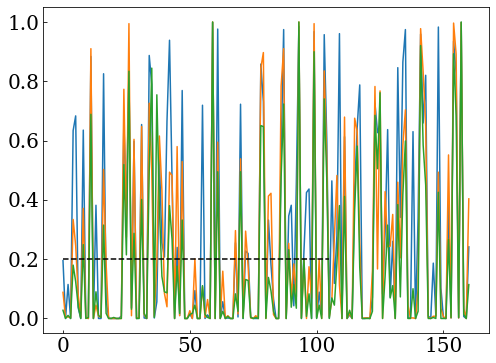

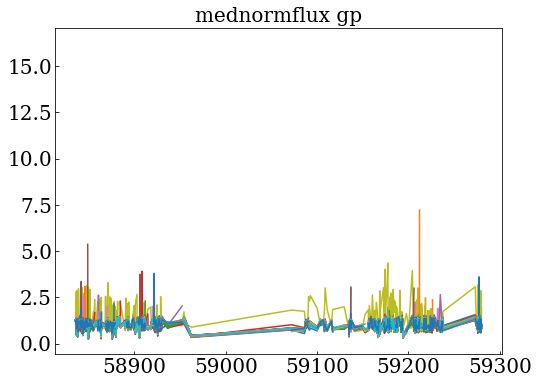

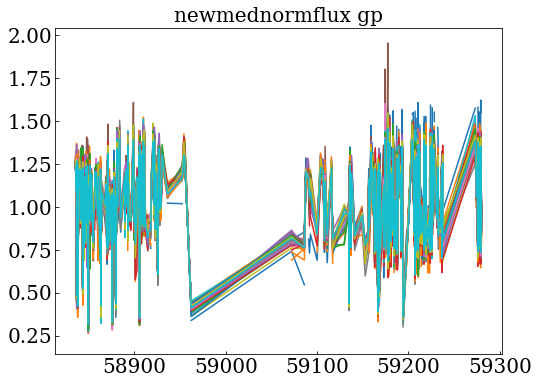

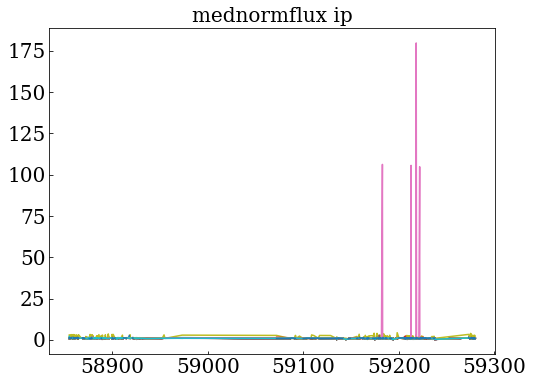

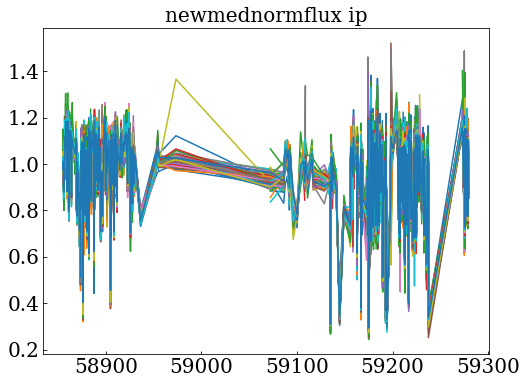

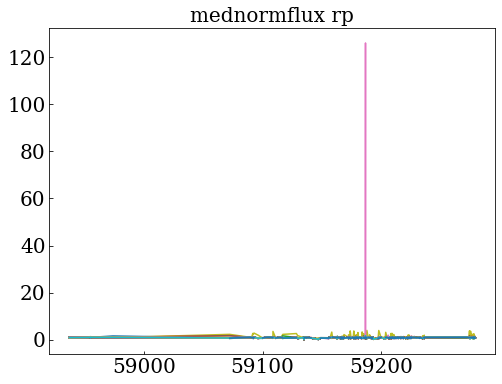

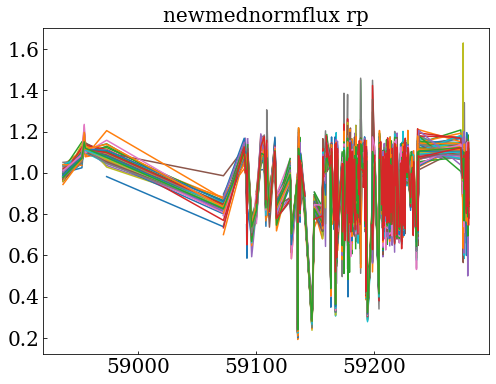

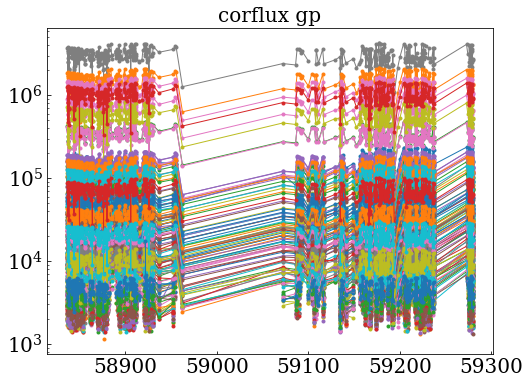

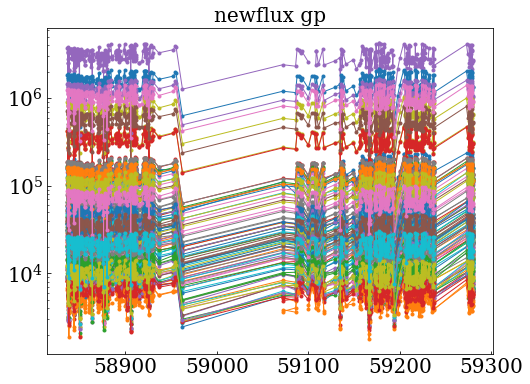

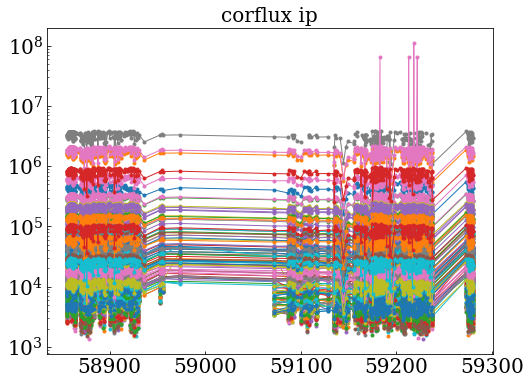

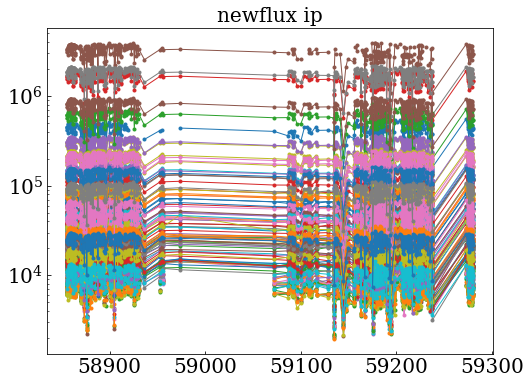

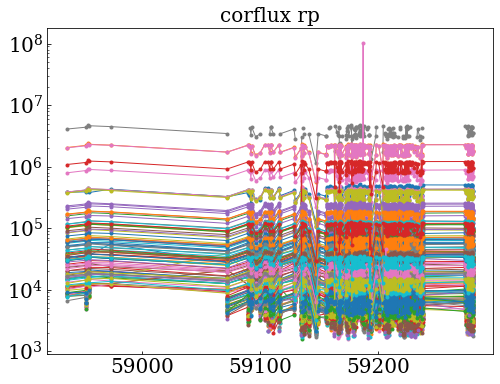

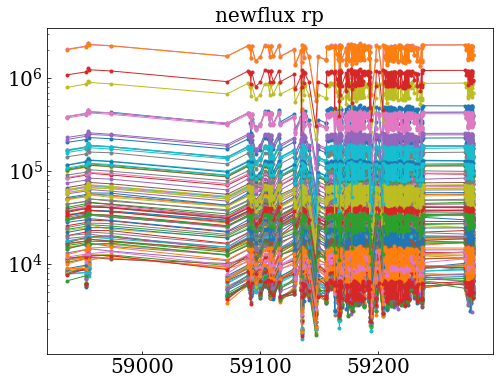

In [127]:
nanper_star = {}
stdcl_mask = {}
for f in filt:
    nanper_star[f] = np.sum(np.isnan(sigcl_flux[f]),axis=0)/len(corepoch[f])
    stdcl_mask[f] = nanper_star[f] < pernan_sigclip #percentage of NaN values above which a star is excluded
    print ("Selected stars {}/{} ({:.3f}%)".format(np.sum(stdcl_mask[f]),len(stdcl_mask[f]),
                                                   100*np.sum(stdcl_mask[f])/len(stdcl_mask[f])))
    plt.plot(nanper_star[f])
plt.plot([0,105],[pernan_sigclip]*2,c='black',linestyle='dashed')
plt.show()

newflux = {}
newfluxerr = {}
newmednormflux = {}
for f in filt:
    newflux[f] = ((sigcl_flux[f].transpose())[stdcl_mask[f]]).transpose()
    newfluxerr[f] = ((sigcl_fluxerr[f].transpose())[stdcl_mask[f]]).transpose()
    newmednormflux[f] = ((sigcl_mednormflux[f].transpose())[stdcl_mask[f]]).transpose()

for f in filt:
    plt.plot(corepoch[f],mednormflux[f])
    plt.title("mednormflux " + f)
    plt.show()
    plt.plot(corepoch[f],newmednormflux[f])
    plt.title("newmednormflux " + f)
    plt.show()

for f in filt:
    plt.plot(corepoch[f],corflux[f],marker='.',linewidth=1)
    plt.title("corflux "+f)
    plt.yscale('log')
    plt.show()
    plt.plot(corepoch[f],newflux[f],marker='.',linewidth=1)
    plt.title("newflux "+f)
    plt.yscale('log')
    plt.show()

### Step iii)

In [128]:
initialw = {}
for f in filt:
    initialw[f] = np.nanmedian(newflux[f],axis=0)

def ALC_func(F,ep, inw, w):
    tmp = []
    
    for e in range(len(ep)):
        noNaN = np.isnan(F[e]) == False
        ALC_i = np.sum(((F[e]*w)/(inw))[noNaN]) / np.sum(w[noNaN])
        tmp.append(ALC_i)
        
    return np.array(tmp)

ALC = {}
for f in filt:
    ALC[f] = ALC_func(newflux[f],corepoch[f], initialw[f], initialw[f])

### Step iv)

In [129]:
def weight_func(F, ep, inw, ALC):
    
    w_ij = []
    for e in range(len(ep)):
        w_j = ((F[e]/inw) *(1/(ALC[e])))
        w_ij.append(w_j)
    
    return (1/np.sqrt(np.nanmean(np.array(w_ij)**2,axis=0)))**2 

#neww = {}
#for f in filt:
#    neww[f] = weight_func(newflux[f],corepoch[f],initialw[f],ALC[f])

### Step v)

In [130]:
i = 0
neww = {}

test = {}
for f in filt:
    test[f] = []

while i < 20:
    i += 1
    
    for f in filt:
        neww[f] = weight_func(newflux[f],corepoch[f],initialw[f],ALC[f])
        test[f].append(neww[f])
    
    for f in filt:
        ALC[f] = ALC_func(newflux[f],corepoch[f], initialw[f], neww[f])
    


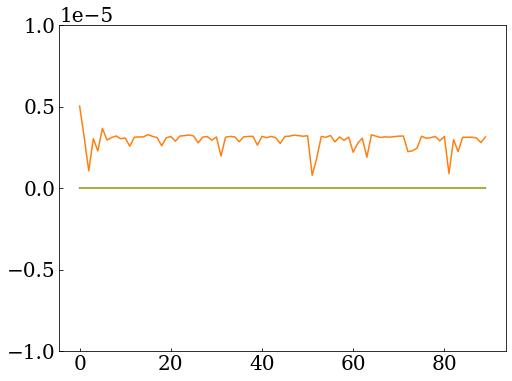

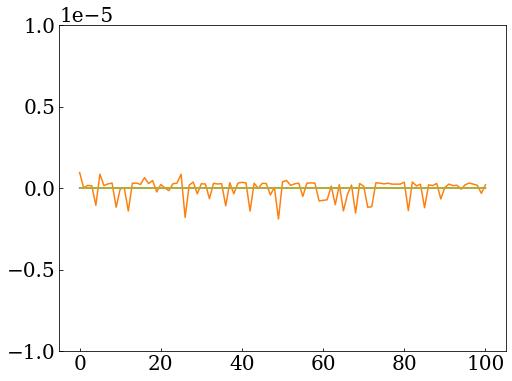

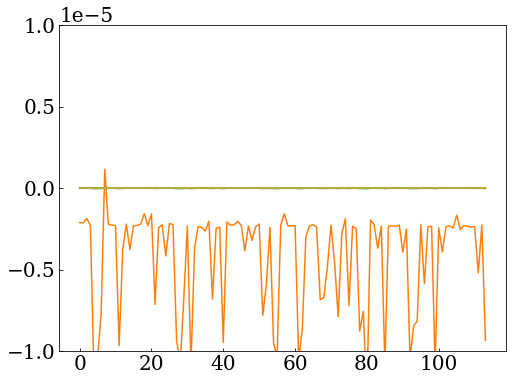

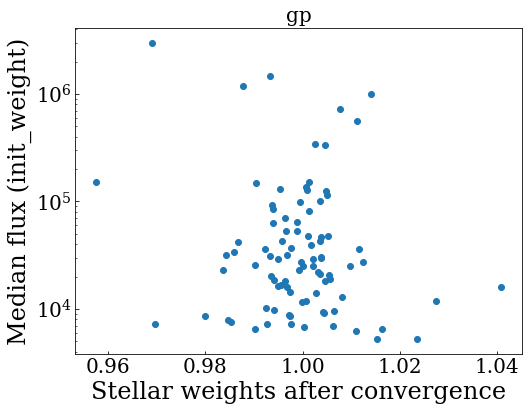

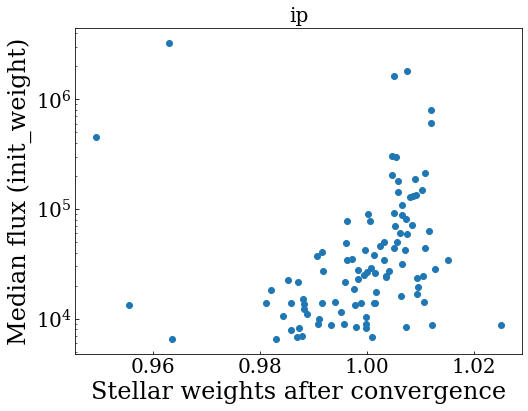

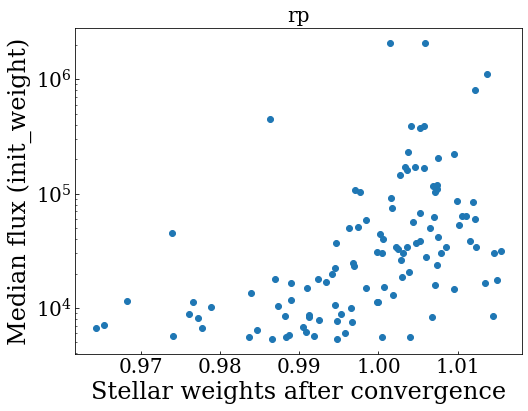

In [138]:
# Check if wights converge within 1e-5

for f in filt:
    for i in range(1,20):
        plt.plot(np.array(test[f][i-1])-np.array(test[f][i]))
        #plt.yscale('log')
    plt.ylim([-1e-5,1e-5])
    plt.show()

# Plot the weights against the median_flux values (so initial weight)
for f in filt:
    plt.scatter(neww[f],np.nanmedian(newflux[f].transpose()/ALC[f],axis=1))
    plt.yscale('log')
    plt.ylabel("Median flux (init_weight)")
    plt.xlabel("Stellar weights after convergence")
    plt.title(f)
    plt.show()


### Step vi)

In [132]:
from scipy import optimize

def RMS(arr):
    return np.sqrt(np.nanmean((np.nanmean(arr)-arr)**2))

def starRMS_model(F, a,b,c):
    return a*np.sqrt((1/F) + (b/(F**2)) + c)

In [162]:
medflux = {}
for f in filt:
    medflux[f] = np.nanmedian(newflux[f].transpose()/ALC[f],axis=1)
    

RMS_afterALC = {}
for f in filt:
    tmp = []
    for s in range(len(newflux[f][0])):
        tmp.append(RMS((newflux[f][:,s]/ALC[f])/medflux[f][s]))
    RMS_afterALC[f] = np.array(tmp)

fitpar = {}
fitparerr = {}
for f in filt:
    popt, pcov = optimize.curve_fit(starRMS_model, medflux[f],RMS_afterALC[f])#,sigma=(RMS_afterALC[f]))
    fitpar[f] = popt
    fitparerr[f] = np.sqrt(np.diag(pcov))

<ipython-input-132-0d83ca4f25c5>:8: RuntimeWarning: invalid value encountered in sqrt
  return a*np.sqrt((1/F) + (b/(F**2)) + c)


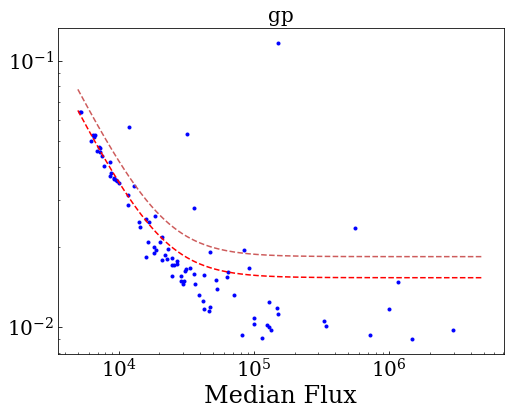

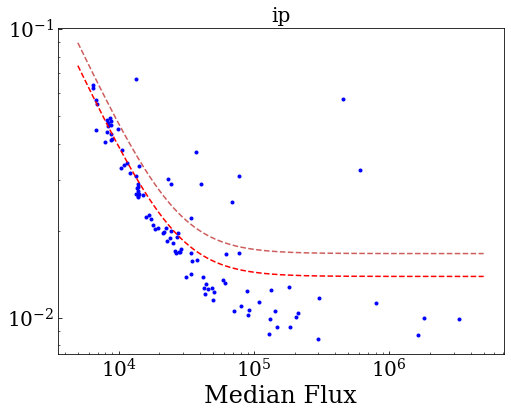

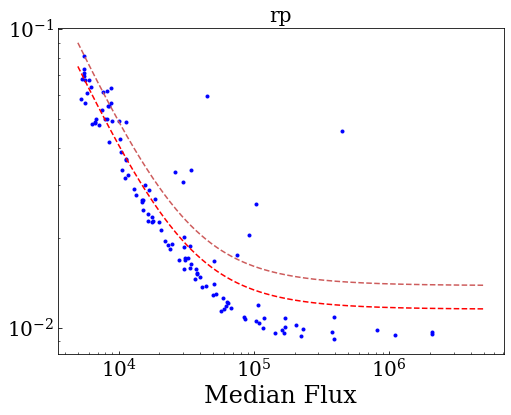

In [167]:
x = np.linspace(5e3,5e6,10000)
for f in filt:
    plt.plot(x,starRMS_model(x,*fitpar[f]),c='r',linestyle='dashed')
    plt.plot(x,1.2*starRMS_model(x,*fitpar[f]),c='indianred',linestyle='dashed')
    #for s in np.arange(len(newflux[f][0])):
        #plt.scatter(medflux[f][s],RMS_afterALC[f][s],marker='.',label='s')
    #plt.errorbar(medflux[f],RMS_afterALC[f],yerr=(RMS_afterALC[f])**2,fmt='.',c='b')
    plt.scatter(medflux[f],RMS_afterALC[f],marker='.',c='b')
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Median Flux')
    plt.title(f)
    plt.show()

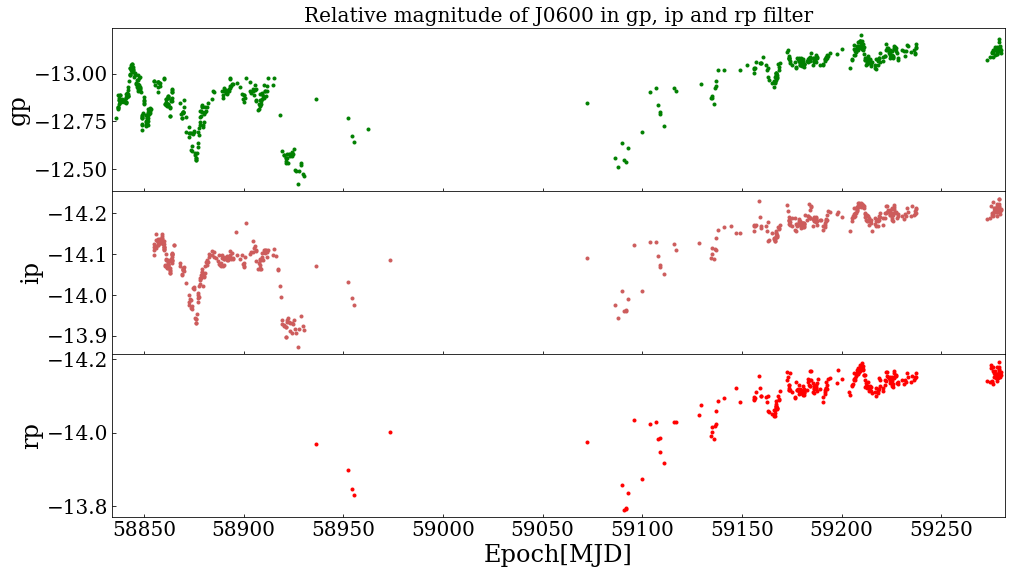

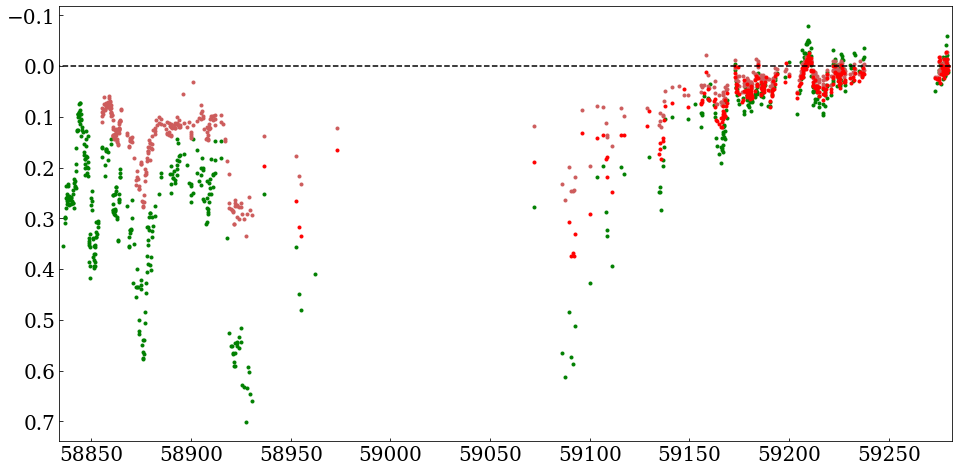

In [168]:
tmp2 = {'gp':'g','ip':'indianred','rp':'r'}

fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
#fig.title('Magnitude of J0600 in gp and rp filter ')
fig.set_figheight(9)
fig.set_figwidth(16)
axs[0].set_title('Relative magnitude of J0600 in gp, ip and rp filter')
for i in range(len(filt)):
    #axs[i].plot([0,1e6],[J0600_gaiamag[f],J0600_gaiamag[f]],c='black',linestyle='dashed')
    axs[i].scatter(corepoch[filt[i]], -2.5*np.log10(corflux[filt[i]][:,0]/ALC[filt[i]]), marker='.',c=tmp2[filt[i]])
    axs[i].set_ylabel(filt[i])
    axs[i].invert_yaxis()
axs[i].set_xlabel("Epoch[MJD]")
axs[i].set_xlim([corepoch['gp'][0]-2,corepoch['gp'][-1]+2])

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()
plt.show()


ZP = {}
for f in filt:
    ZP[f] = (-2.5*np.log10(corflux[f][:,0]/ALC[f]))[-1]
    #ZP[f] = np.min(-2.5*np.log10(corflux[f][:,0]/ALC[f]))

plt.figure(figsize=(16,8))
plt.plot([0,1e6],[0,0],c='black',linestyle='dashed')
for f in filt:
    plt.scatter(corepoch[f], -2.5*np.log10(corflux[f][:,0]/ALC[f])-ZP[f], marker='.',c=tmp2[f])
plt.gca().invert_yaxis()
plt.xlim([corepoch['gp'][0]-2,corepoch['gp'][-1]+2])
plt.show()

In [171]:
#Use Interpolate to map rp datapoints on gp
#Use color of datapoints in plot to signal epoch
from scipy import interpolate

f1 = interpolate.interp1d(corepoch['ip'],-2.5*np.log10(corflux['ip'][:,0]/ALC['ip']))

m1 = epoch['gp'] > np.min(epoch['ip']) # or 59050 as max epoch
m2 = epoch['gp'] < np.max(epoch['ip'])
J0600_rp_interp = f1(epoch['gp'][m1*m2])



ValueError: A value in x_new is below the interpolation range.

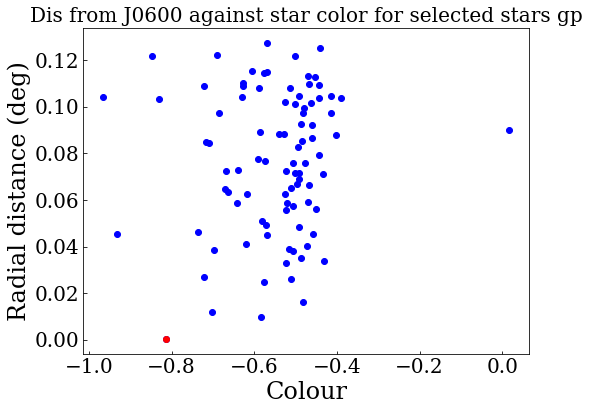

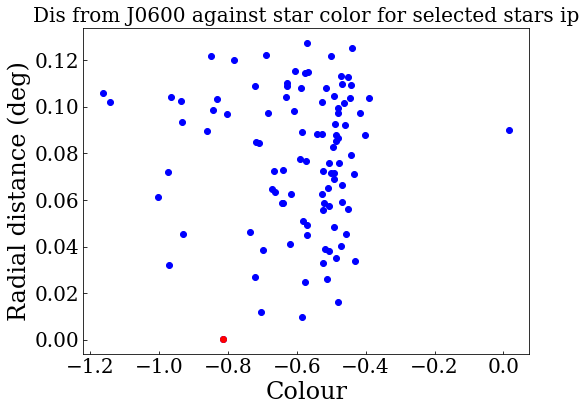

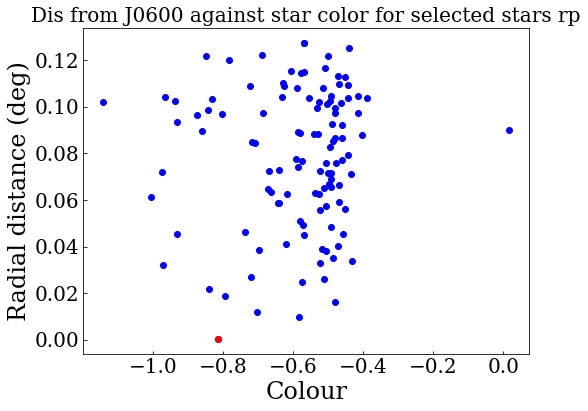

In [169]:
for f in filt:
    d_to_J0600 = distance(90.00316332976436, -31.007910088843165,\
                          r['ra'][gaiamask[f]][stdcl_mask[f]],r['dec'][gaiamask[f]][stdcl_mask[f]])
    
    plt.scatter(gaia_c[f][stdcl_mask[f]], d_to_J0600,c='b')
    plt.scatter((J0600_gaia['phot_rp_mean_mag']-J0600_gaia['phot_g_mean_mag']),np.min(d_to_J0600),c='r')
    plt.xlabel('Colour')
    plt.ylabel('Radial distance (deg)')
    plt.title('Dis from J0600 against star color for selected stars '+f)
    plt.show()